In [14]:
import numpy as np
from astropy.io import ascii
from scipy.interpolate import interp1d
import astropy.units as u
from astropy import constants
ls_mic = 2.99792458e14 #micron/s

def blackcgs(T, nu):
    h = 6.625e-27
    k = 1.38e-16
    cs = 2.99792458e10
    firstterm = 2*h*nu**3/cs**2
    x = h*nu/(k*T)
    exppart = 1/(np.exp(x)-1)
    bnu = firstterm*exppart
# calculate blam and return it if keyword lamb is set
#if keyword_set(lamb) then begin
#blam = bnu*nu/(3*10**10/nu) 
#return(blam)
    return(bnu)

def BandFunc_mono(wave0, wavelength, spc, rsr, alpha):
    freq = (ls_mic / wavelength)
    nu0 = ls_mic / wave0
    Sv = freq**alpha
    fluxFltr = nu0**alpha * np.trapz(rsr*spc, freq) / np.trapz(rsr*Sv, freq)
    return (fluxFltr)

def BandFunc_mips(wave0, wavelength, spc, rsr, T):
    freq = (ls_mic / wavelength)
    nu0 = ls_mic / wave0
    fluxFltr = blackcgs(T, nu0) * np.trapz(rsr*spc, freq) / np.trapz(rsr*blackcgs(T, freq), freq)
    return (fluxFltr)

def BandFunc_mean(wavelength, spc, rsr):
    signal = np.trapz(rsr*spc/wavelength, x=wavelength)
    norm   = np.trapz(rsr/wavelength, x=wavelength)        # spc = nv^0
    fluxFltr = signal/norm
    return (fluxFltr)

def BandFunc_mono_unc(wave0, wave, sigma, rsr, alpha):
    nu0 = ls_mic / wave0
    freq = ls_mic / wave
    Sv = freq**alpha
    Psigma = nu0**alpha * np.sqrt(np.trapz((rsr*sigma/wave**2)**2, wave)) / np.trapz(rsr*Sv/wave**2, wave)
    return (Psigma)

def BandFunc_mips_unc(wave0, wave, sigma, rsr, T):
    nu0 = ls_mic / wave0
    freq = ls_mic / wave
    Psigma = blackcgs(T, nu0) * np.sqrt(np.trapz((rsr*sigma/wave**2)**2, wave)) / np.trapz(rsr*blackcgs(T, freq)/wave**2, wave)
    return (Psigma)

def BandFunc_mean_unc(wave, sigma, rsr):
    signal = np.sqrt(np.trapz((rsr*sigma/wave)**2, x=wave))
    norm   = np.trapz(rsr/wave, x=wave)
    Psigma = signal/norm
    return (Psigma)

monoFilters = ["Herschel_PACS_70", "Herschel_PACS_100", "Herschel_PACS_160",
               "Herschel_SPIRE_250", "Herschel_SPIRE_350", "Herschel_SPIRE_500",
               "Herschel_SPIRE_250_e", "Herschel_SPIRE_350_e", "Herschel_SPIRE_500_e",
               "Spitzer_IRAC1", "Spitzer_IRAC2", "Spitzer_IRAC3", "Spitzer_IRAC4",
               "IRAS_12", "IRAS_25", "IRAS_60", "IRAS_100","IRC_S7","IRC_S11","IRC_L15","IRC_L24"]
mipsFilters = ["Spitzer_MIPS_24", "Spitzer_MIPS_70", "Spitzer_MIPS_160"]
meanFilters = ["2MASS_J", "2MASS_H", "2MASS_Ks",
               "WISE_w1", "WISE_w2", "WISE_w3", "WISE_w4"]

filterDict = {
    "2MASS_J": 1.235,
    "2MASS_H": 1.662,
    "2MASS_Ks": 2.159,
    "WISE_w1": 3.353,
    "WISE_w2": 4.603,
    "WISE_w3": 11.561,
    "WISE_w4": 22.088,
    "IRC_S7": 7.0,
    "IRC_S11": 11.0,
    "IRC_L15": 15.0,
    "IRC_L24": 24.0,
    "Herschel_PACS_70": 70.,
    "Herschel_PACS_100": 100.,
    "Herschel_PACS_160": 160.,
    "Herschel_SPIRE_250": 250.,
    "Herschel_SPIRE_350": 350.,
    "Herschel_SPIRE_500": 500.,
    "Spitzer_IRAC1": 3.550,
    "Spitzer_IRAC2": 4.493,
    "Spitzer_IRAC3": 5.731,
    "Spitzer_IRAC4": 7.872,
    "IRAS_12": 12.,
    "IRAS_25": 25.,
    "IRAS_60": 60.,
    "IRAS_100": 100.,
    "Spitzer_MIPS_24": 23.675,
    "Spitzer_MIPS_70": 71.440,
    "Spitzer_MIPS_160": 155.899,
    "JCMT_SCUBA1_450": 450.,
    "JCMT_SCUBA1_850": 850.,
}

def Photometry(wavelength, spectrum, band):

    bandPath = '/Users/zhangl/Applications/Fitter/sedfit/filters/'
    bandFile = "{0}.dat".format(band)
    bandPck = np.genfromtxt(bandPath+bandFile)
    bandWave = bandPck[:, 0]
    bandRsr = bandPck[:, 1]
    ma1 = bandWave>=wavelength.min()
    ma2 = bandWave<=wavelength.max()
    ma = ma1*ma2
    bandWave = bandWave[ma]
    bandRsr = bandRsr[ma]
    all_wave = np.concatenate((wavelength, bandWave))
    sort_all = sorted(all_wave)
    unique_sort_all = np.unique(sort_all)
    ma1 = unique_sort_all >= bandWave.min()
    ma2 = unique_sort_all <= bandWave.max()
    new_wavelengths = unique_sort_all[ma1*ma2]
    fs = interp1d(wavelength, spectrum, kind='cubic')
    spc = fs(new_wavelengths)
    fr = interp1d(bandWave, bandRsr, kind='cubic')
    rsr = fr(new_wavelengths)
    if band in monoFilters:
        Phot = BandFunc_mono(filterDict[band], new_wavelengths, spc, rsr, -1)
    elif band in mipsFilters:
        Phot = BandFunc_mips(filterDict[band], new_wavelengths, spc, rsr, 10000)
    elif band in meanFilters:
        Phot = BandFunc_mean(new_wavelengths, spc, rsr)
    else:
        raise ValueError("The input band ({0}) is incorrect!".format(bn))
    return(Phot)

def Photometry_unc(wavelength, sigma, band):

    lightspd = (constants.c).to('cm/s').value
    bandPath = '/Users/zhangl/Applications/Fitter/sedfit/filters/'
    bandFile = "{0}.dat".format(band)
    bandPck = np.genfromtxt(bandPath+bandFile)
    bandWave = bandPck[:, 0]
    bandRsr = bandPck[:, 1]
    ma1 = wavelength>=bandWave.min()
    ma2 = wavelength<=bandWave.max()
    ma = ma1*ma2
    wavelength = wavelength[ma]
    sigma = sigma[ma]
    fr = interp1d(bandWave, bandRsr, kind='cubic')
    rsr = fr(wavelength)
    if band in monoFilters:
        Phot = BandFunc_mono_unc(filterDict[band], wavelength, sigma, rsr, -1)
    elif band in mipsFilters:
        Phot = BandFunc_mips_unc(filterDict[band], wavelength, sigma, rsr, 10000)
    elif band in meanFilters:
        Phot = BandFunc_mean_unc(wavelength, sigma, rsr)
    else:
        raise ValueError("The input band ({0}) is incorrect!".format(bn))
    return(Phot)

def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    if('CROTA2' in hdu):
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    else:
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('PC1_1',hdu['PC1_1']),('PC2_1',hdu['PC2_1']),('PC1_2',hdu['PC1_2']),
                ('PC2_2',hdu['PC2_2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y , 1)
    return [recx, recy]

def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    if('CROTA2' in hdu):
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    else:
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('PC1_1',hdu['PC1_1']),('PC2_1',hdu['PC2_1']),('PC1_2',hdu['PC1_2']),
                ('PC2_2',hdu['PC2_2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y , 1)
    return [recx, recy]

In [18]:
def Montage_Reproject(name, mode, O2, dirsc, scale, rp, rpu, rpo):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.table import Table

    path = '/Users/zhangl/desktop/SINGS/{0}/{1}/'.format(dirsc, name)
    rp_file = path + rp
    rpu_file = path + rpu
#    pathhh = '/Users/zhangl/desktop/SINGS/Cube/{0}/'.format(name)
#    rp_file = pathhh + '{0}_DR5_{1}_cube.fits'.format(name,mode)
#    rpu_file = pathhh + '{0}_DR5_{1}_cube_unc.fits'.format(name,mode)

    if(os.path.isfile(rp_file)==False):
        print('No such path or file:{0}'.format(rp_file))
        return ()
    rp_fits = fits.open(rp_file)
    data = rp_fits[0].data
    data = data.sum(axis=0)
    data = np.transpose(data, axes=(1,0))
    header = rp_fits[0].header
    indcube = np.full((header['NAXIS1']+20, header['NAXIS2']+20), 0)
    mask = np.isnan(data)
    indcube[10:-10,10:-10][~mask] = 1
    header['NAXIS1'] = header['NAXIS1'] + 20
    header['NAXIS2'] = header['NAXIS2'] + 20
    header['CRPIX1'] = header['CRPIX1'] + 10
    header['CRPIX2'] = header['CRPIX2'] + 10
    indcube = np.transpose(indcube, axes=(1, 0))
    img = fits.PrimaryHDU(indcube, header=header)
    dirs = 'IndC/{0}'.format(name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    img.writeto('{0}/ind_{1}.fits'.format(dirs, mode), overwrite = True)

    p_file = path + rpo
    if(os.path.isfile(p_file)==False):
        print('No such path or file:{0}'.format(p_file))
        return()
    flux_header = fits.open(p_file)[0].header
    dirs = 'HdrText_{0}/{1}_{2}/{3}'.format(O2, dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    hdr = open('HdrText_{0}/{1}_{2}/{3}/{3}_{4}_hdr.txt'.format(O2, dirsc, scale, name, mode),'w')
    sdu = fits.open(p_file)[0].data
    sdu = sdu.sum(axis=0)
    sdu = np.transpose(sdu, axes=(1,0))
    mask = np.isnan(sdu)
    blank = np.where(mask == True)
    ma = blank[0] == blank[0].max()
    while(ma.sum() < flux_header['NAXIS2']-3):
        blank[0][ma] = 0
        ma = blank[0] == blank[0].max()
    CRPIX1 = (blank[0].max() + 1 + flux_header['NAXIS1'])//2
    CRPIX2 = (1 + flux_header['NAXIS2'])//2
    coor_mode = wcss(flux_header, [CRPIX1], [CRPIX2])
    CRVAL1 = coor_mode[0][0]
    CRVAL2 = coor_mode[1][0]
    hdr.write('SIMPLE  = T\nBITPIX  = -64\nNAXIS   = 3\n')
    hdr.write('NAXIS1  = {0}\n'.format(flux_header['NAXIS1']))
    hdr.write('NAXIS2  = {0}\n'.format(flux_header['NAXIS2']))
    hdr.write('NAXIS3  = {0}\n'.format(header['NAXIS3']))
    hdr.write('CTYPE1  = {0}\n'.format(flux_header['CTYPE1']))
    hdr.write('CTYPE2  = {0}\n'.format(flux_header['CTYPE2']))
    hdr.write('EQUINOX  = {0}\n'.format(flux_header['EQUINOX']))
    hdr.write('CRVAL1  = {0}\n'.format(CRVAL1))
    hdr.write('CRVAL2  = {0}\n'.format(CRVAL2))
    hdr.write('CRVAL3  = {0}\n'.format(flux_header['CRVAL3']))
    hdr.write('CRPIX1  = {0}\n'.format(str((flux_header['NAXIS1']+1)//2)))
    hdr.write('CRPIX2  = {0}\n'.format(str((flux_header['NAXIS2']+1)//2)))
    hdr.write('CRPIX3  = {0}\n'.format(flux_header['CRPIX3']))
    hdr.write('CDELT1  = {0}\n'.format(str(-10/3600)))
    hdr.write('CDELT2  = {0}\n'.format(str(10/3600)))
#    hdr.write('CDELT1  = {0}\n'.format(flux_header['CDELT1']))
#    hdr.write('CDELT2  = {0}\n'.format(flux_header['CDELT2']))
    hdr.write('CDELT3  = {0}\n'.format(str(0)))
#        hdr.write('PC1_1  = {0}\n'.format(p_fits[0].header['PC1_1']))
#        hdr.write('PC2_1  = {0}\n'.format(p_fits[0].header['PC2_1']))
#        hdr.write('PC1_2  = {0}\n'.format(p_fits[0].header['PC1_2']))
#        hdr.write('PC2_2  = {0}\n'.format(p_fits[0].header['PC2_2']))
    Ro2_s = np.arcsin(flux_header['PC2_1']*flux_header['CDELT2']/flux_header['CDELT1'])*180/np.pi
    Ro22_s = [round(Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7), round(Ro2_s*180/np.abs(Ro2_s)-Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7)]
    Ro2_c = np.arccos(flux_header['PC1_1'])*180/np.pi
    Ro22_c = [round(Ro2_c,7), round(360-Ro2_c,7)]
    Ro2 = list(set(Ro22_s).intersection(Ro22_c))[0]
    hdr.write('CROTA2  = {0}\n'.format(str(Ro2)))
    hdr.write('BUNIT  = MJy_sr^-1\n')
    hdr.write('END')
    hdr.close()
    dirs = 'Projection_{0}/{1}_{2}/{3}'.format(O2, dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    ind_file = 'IndC/{0}/ind_{1}.fits'.format(name, mode)
    os.system('mProjectCube -f {0} Projection_{1}/{2}_{3}/{4}/{5}_on2_{1}.fits HdrText_{1}/{2}_{3}/{4}/{4}_{5}_hdr.txt'.format(rp_file,O2,dirsc,scale,name,mode))
    os.system('mProject -f {0} Projection_{1}/{2}_{3}/{4}/{4}_{5}ind.fits HdrText_{1}/{2}_{3}/{4}/{4}_{5}_hdr.txt'.format(ind_file,O2,dirsc,scale,name,mode))
    Montage = '/Users/zhangl/Software/Montage2/bin/'
    os.system('{0}mProjectCube -f {1} Projection_{2}/{3}_{4}/{5}/{6}_on2_{2}_unc.fits HdrText_{2}/{3}_{4}/{5}/{5}_{6}_hdr.txt'.format(Montage,rpu_file,O2,dirsc,scale,name,mode))
#        sr1 = np.abs(rp_fits[0].header['CDELT1'])**2
#        sr2 = np.abs(p_fits[0].header['CDELT1'])**2

    rpd_file = 'Projection_{0}/{1}_{2}/{3}/{4}_on2_{0}.fits'.format(O2,dirsc,scale,name,mode)
    Spec_hdu = fits.open(rpd_file)[0]
#        Spec_hdu.data = Spec_hdu.data*sr1/sr2
    Spec_hdu.header['BUNIT'] = 'MJy/sr'
    Wave_hdu = rp_fits[1]
    hdul = fits.HDUList([Spec_hdu,Wave_hdu])
    hdul.writeto('Projection_{0}/{1}_{2}/{3}/{4}_on2_{0}.fits'.format(O2,dirsc,scale,name,mode), overwrite = True)
    rpud_file = 'Projection_{0}/{1}_{2}/{3}/{4}_on2_{0}_unc.fits'.format(O2,dirsc,scale,name,mode)
    Spec_hdu = fits.open(rpud_file)[0]
#        Spec_hdu.data = Spec_hdu.data*sr1/sr2
    Spec_hdu.header['BUNIT'] = 'MJy/sr'
    Wave_hdu = rp_fits[1]
    hdul = fits.HDUList([Spec_hdu,Wave_hdu])
    hdul.writeto('Projection_{0}/{1}_{2}/{3}/{4}_on2_{0}_unc.fits'.format(O2,dirsc,scale,name,mode), overwrite = True)
    rp_fits.close()
    return ()

def Montage_Reproject_Img(name, band, O2, dirsc, scale, dirsi):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.table import Table

    p_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name,O2)
    if(os.path.isfile(p_file)==False):
        print('No such path or file:{0}'.format(p_file))
        return ()
    else:
        Img_header = fits.open(p_file)[0].header
    dirs = 'HdrText_{0}/{1}_{2}/{3}'.format(O2, dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    hdr = open('{0}/{1}_hdr.txt'.format(dirs, band),'w')
    rp_file = 'IMAGE/{0}/{1}_{2}.fits'.format(dirsi, name, band)
    rpu_file = 'IMAGE/{0}/{1}_{2}_unc.fits'.format(dirsi, name, band)
    if(os.path.isfile(rp_file)==False):
        print('No such path or file:{0}'.format(rp_file))
        return ()
    sdu = fits.open(p_file)[0].data
    sdu = sdu.sum(axis=0)
    sdu = np.transpose(sdu, axes=(1,0))
    mask = np.isnan(sdu)
    blank = np.where(mask == True)
    ma = blank[0] == blank[0].max()
    while(ma.sum() < Img_header['NAXIS2']-3):
        blank[0][ma] = 0
        ma = blank[0] == blank[0].max()
    CRPIX1 = (blank[0].max() + 1 + Img_header['NAXIS1'])//2
    CRPIX2 = (1 + Img_header['NAXIS2'])//2
    coor_mode = wcss(Img_header, [CRPIX1], [CRPIX2])
    CRVAL1 = coor_mode[0][0]
    CRVAL2 = coor_mode[1][0]
    hdr.write('SIMPLE  = T\nBITPIX  = -64\nNAXIS   = 2\n')
    hdr.write('NAXIS1  = {0}\n'.format(Img_header['NAXIS1']))
    hdr.write('NAXIS2  = {0}\n'.format(Img_header['NAXIS2']))
    hdr.write('CTYPE1  = {0}\n'.format(Img_header['CTYPE1']))
    hdr.write('CTYPE2  = {0}\n'.format(Img_header['CTYPE2']))
    hdr.write('EQUINOX  = {0}\n'.format(Img_header['EQUINOX']))
    hdr.write('CRVAL1  = {0}\n'.format(CRVAL1))
    hdr.write('CRVAL2  = {0}\n'.format(CRVAL2))
    hdr.write('CRPIX1  = {0}\n'.format(str((Img_header['NAXIS1']+1)//2)))
    hdr.write('CRPIX2  = {0}\n'.format(str((Img_header['NAXIS2']+1)//2)))
    hdr.write('CDELT1  = {0}\n'.format(str(-10/3600)))
    hdr.write('CDELT2  = {0}\n'.format(str(10/3600)))
#        hdr.write('PC1_1  = {0}\n'.format(p_fits[0].header['PC1_1']))
#        hdr.write('PC2_1  = {0}\n'.format(p_fits[0].header['PC2_1']))
#        hdr.write('PC1_2  = {0}\n'.format(p_fits[0].header['PC1_2']))
#        hdr.write('PC2_2  = {0}\n'.format(p_fits[0].header['PC2_2']))
    Ro2_s = np.arcsin(Img_header['PC2_1']*Img_header['CDELT2']/Img_header['CDELT1'])*180/np.pi
    Ro22_s = [round(Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7), round(Ro2_s*180/np.abs(Ro2_s)-Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7)]
    Ro2_c = np.arccos(Img_header['PC1_1'])*180/np.pi
    Ro22_c = [round(Ro2_c,7), round(360-Ro2_c,7)]
    Ro2 = list(set(Ro22_s).intersection(Ro22_c))[0]
    hdr.write('CROTA2  = {0}\n'.format(str(Ro2)))
    hdr.write('BUNIT  = MJy_sr^-1\n')
    hdr.write('END')
    hdr.close()
    path = 'Projection_{0}/{1}_{2}/{3}'.format(O2, dirsi, scale, name)
    if(os.path.exists(path) != True):
        os.makedirs(path)
    os.system('mProject -f {0} {1}/{2}_{3}.fits HdrText_{4}/{5}_{6}/{2}/{3}_hdr.txt'.format(rp_file,path,name,band,O2,dirsc,scale))
    Montage = '/Users/zhangl/Software/Montage2/bin/'
    os.system('{0}mProject -f {1} {2}/{3}_{4}_unc.fits HdrText_{5}/{6}_{7}/{3}/{4}_hdr.txt'.format(Montage,rpu_file,path,name,band,O2,dirsc,scale))
    photd = fits.open('Projection_{0}/{1}_{2}/{3}/{3}_{4}.fits'.format(O2, dirsi, scale, name, band), mode = 'update')
    photd[0].header['BUNIT'] = 'MJy/sr'
    photd.close()
    photd = fits.open('Projection_{0}/{1}_{2}/{3}/{3}_{4}_unc.fits'.format(O2, dirsi, scale, name, band), mode = 'update')
    photd[0].header['BUNIT'] = 'MJy/sr'
    photd.close()
    return ()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    mode_name = ['SL2', 'SL1', 'LL2', 'LL1']
    Band_list = [['IRAC', 'IRAC1'], ['IRAC', 'IRAC2'], ['IRAC', 'IRAC3'], ['IRAC', 'IRAC4'], 
                 ['MIPS','MIPS24'], ['WISE', 'W1'],  ['WISE', 'W2'],  ['WISE', 'W3'], 
                 ['IRC', 'S7'], ['IRC', 'S11'], ['IRC', 'L15'], ['IRC', 'L24']]
    for name in gal_name:
        for mode in mode_name:
            try:
                Montage_Reproject(name, mode, 'SL1', 'Cube_convl', 10, '{0}_{1}_convolved.fits'.format(name,mode), '{0}_{1}_unc_convolved.fits'.format(name,mode), '{0}_SL1_convolved.fits'.format(name))
                print('Projection of {0} {1} image is OK!'.format(name, mode))
            except:
                print('Something worry happens when reprojecting {0} {1} image!'.format(name, mode))
        for band in Band_list:
            try:
                Montage_Reproject_Img(name, band[1], 'SL1', 'Cube_convl', 10, '{0}_convl'.format(band[0]))
                print('Projection of {0} {1} imaging is OK!'.format(name, band))
            except:
                print('Something worry happens when reproject {0} {1} imaging!'.format(name))

Projection of ngc5194 SL2 image is OK!
Projection of ngc5194 SL1 image is OK!
Projection of ngc5194 LL2 image is OK!
Projection of ngc5194 LL1 image is OK!
Projection of ngc5194 ['IRAC', 'IRAC1'] imaging is OK!
Projection of ngc5194 ['IRAC', 'IRAC2'] imaging is OK!
Projection of ngc5194 ['IRAC', 'IRAC3'] imaging is OK!
Projection of ngc5194 ['IRAC', 'IRAC4'] imaging is OK!
Projection of ngc5194 ['MIPS', 'MIPS24'] imaging is OK!
Projection of ngc5194 ['WISE', 'W1'] imaging is OK!
Projection of ngc5194 ['WISE', 'W2'] imaging is OK!
Projection of ngc5194 ['WISE', 'W3'] imaging is OK!
Projection of ngc5194 ['IRC', 'S7'] imaging is OK!
Projection of ngc5194 ['IRC', 'S11'] imaging is OK!
Projection of ngc5194 ['IRC', 'L15'] imaging is OK!
Projection of ngc5194 ['IRC', 'L24'] imaging is OK!


In [19]:
import numpy as np
from scipy.optimize import leastsq
from scipy.optimize import curve_fit

def func(x, p):
    a, b, c = p
    y = a*x**2 + b*x + c
    return y

def residual(pp, x, y):
    if(x<0):
        x = -x
        diff = pp[-1]*y - func(x, pp[0:3])
    else:
        diff = y - func(x, pp[0:3])
    return diff

def res_vec(pp, x, y):
    dd = np.zeros(x.shape)
    for ii in range(len(dd)):
        dd[ii] = residual(pp, x[ii], y[ii])
    return dd

residual_func = lambda pp, x, y: res_vec(pp, x, y)

def Cal_k(pp, xx, yy):
    k = leastsq(residual_func, pp, args =(xx, yy))[0]
    return k

def Cali_f(x, c):
    y = c*x
    return y

def Cal_s(xdata, ydata, k0, sigma):
    sf = curve_fit(Cali_f, xdata, ydata, k0, sigma)[0][0]
    return sf

def Spectra_redis(name, O2, dirsc, scale):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits
    from astropy.io import ascii
    from astropy import constants
    from astropy.table import Table
    import matplotlib.pyplot as plt


    data_mode = ['SL2', 'SL1', 'LL2', 'LL1']
    nnmm = 'Projection_{0}/{1}_{2}/{3}/'.format(O2, dirsc, scale, name)
    aabb = nnmm + 'SL2_on2_{0}.fits'.format(O2)
    if(os.path.isfile(aabb)):
        cube = fits.open(aabb)
    else:
        print('No such file:{0}'.format(aabb))
        return ()
    flux_header = cube[0].header
    apple = max(flux_header['NAXIS1'],flux_header['NAXIS2']) + 10
    crpixx, crpixy = flux_header['NAXIS1']//2, flux_header['NAXIS2']//2
    coor_mode = wcss(flux_header, [crpixx], [crpixy])
    crval = [[coor_mode[0][0]],[coor_mode[1][0]]]
    cube.close()
    for mode in data_mode:
        aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
        aacc = nnmm + '{0}_on2_{1}_unc.fits'.format(mode, O2)
        if(os.path.isfile(aabb)):
            cube = fits.open(aabb)
            cube_u = fits.open(aacc)
        else:
            print('No such file:{0}'.format(aabb))
            continue
        flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
        flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
        flux_header = cube['PRIMARY'].header
        orange = flux_header['NAXIS3']
        banana = np.full((apple, apple, orange), np.nan)
        banana_u = np.full((apple, apple, orange), np.nan)
        crpix = wcss3(flux_header, [crval[0][0]], [crval[1][0]])
        xx = int(round(crpix[0][0],0))
        yy = int(round(crpix[1][0],0))
        mm1 = max(0, xx-apple//2)
        mm2 = min(xx+apple-apple//2,flux_header['NAXIS1'])
        nn1 = max(0, yy-apple//2)
        nn2 = min(yy+apple-apple//2,flux_header['NAXIS2'])
        for ii in range(mm1,mm2):
            for jj in range(nn1,nn2):
                banana[apple//2 + ii-xx, apple//2 + jj-yy] = flux[ii, jj]
                banana_u[apple//2 + ii-xx, apple//2 + jj-yy] = flux_u[ii, jj]
        CARD = [('NAXIS1',apple),('NAXIS2',apple),('NAXIS3',orange),('CTYPE1',flux_header['CTYPE1']),('CTYPE2',flux_header['CTYPE2']),
                ('EQUINOX',flux_header['EQUINOX']),('CRVAL1',crval[0][0]),('CRVAL2',crval[1][0]),('CRVAL3',flux_header['CRVAL3']),
                ('CRPIX1',apple//2+1),('CRPIX2',apple//2+1),('CRPIX3',flux_header['CRPIX3']),('CDELT1',flux_header['CDELT1']),
                ('CDELT2',flux_header['CDELT2']),('CDELT3',flux_header['CDELT3']),('CROTA2',flux_header['CROTA2']),('BUNIT',flux_header['BUNIT'])]
        hdr = fits.Header(cards= CARD)
        banana = np.transpose(banana, axes=(2, 1, 0))
        primary_hdu = fits.PrimaryHDU(banana, header=hdr)
        hdu_wav = cube['WCS-TAB']
        hdul = fits.HDUList([primary_hdu, hdu_wav])
        dirs = 'ReProjection/{0}_{1}/{2}'.format(dirsc, scale, name)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        hdul.writeto('ReProjection/{0}_{1}/{2}/{3}_on2_{4}.fits'.format(dirsc,scale,name,mode,O2), overwrite = True)
        banana_u = np.transpose(banana_u, axes=(2, 1, 0))
        primary_hdu = fits.PrimaryHDU(banana_u, header=hdr)
        hdu_wav = cube['WCS-TAB']
        hdul = fits.HDUList([primary_hdu, hdu_wav])
        hdul.writeto('ReProjection/{0}_{1}/{2}/{3}_on2_{4}_unc.fits'.format(dirsc,scale,name,mode,O2), overwrite = True)
        cube.close()
        cube_u.close()
###---------------------------------------------------------------------------------------------------------------
### here to scale the spectra within different wavelength range
###---------------------------------------------------------------------------------------------------------------
    Spec = []
    Spec_u = []
    Wave = []
    for mode in data_mode:
        aadd = 'ReProjection/{0}_{1}/{2}/{3}_on2_{4}.fits'.format(dirsc,scale,name,mode,O2)
        aaee = 'ReProjection/{0}_{1}/{2}/{3}_on2_{4}_unc.fits'.format(dirsc,scale,name,mode,O2)
        if(os.path.isfile(aadd)):
            cube = fits.open(aadd)
            cube_u = fits.open(aaee)
        else:
            print('No such file:{0}'.format(aadd))
            continue
        Sspec = cube[0].data
        Sspec_u = cube_u[0].data
        Wwave = cube[1].data
        Spec.append(Sspec)
        Spec_u.append(Sspec_u)
        Wave.append(Wwave)
    Spec = np.array(Spec)
    Spec_u = np.array(Spec_u)
    Wave = np.array(Wave)
    shape = Spec[0][0].shape
    S2_S1 = np.ones(Spec[0][0].shape)
    ma1 = Wave[0][0][0].sum(axis=1)>7.4
    ma2 = Wave[1][0][0].sum(axis=1)<7.9
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[0][0][0].sum(axis=1)[ma1]) + list(Wave[1][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[0][ma1,ii,jj]) + list(Spec[1][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                S2_S1[ii,jj] = kk[-1]
#                plt.scatter(Wave[0][0][0].sum(axis=1)[ma1], S2_S1[ii,jj]*Spec[0][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[1][0][0].sum(axis=1)[ma2], Spec[1][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    L2_L1 = np.ones(Spec[0][0].shape)
    ma11 = Wave[2][0][0].sum(axis=1)>19.5
    ma12 = Wave[2][0][0].sum(axis=1)<21
    ma1 = ma11*ma12
    ma2 = Wave[3][0][0].sum(axis=1)<22.5
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[2][0][0].sum(axis=1)[ma1]) + list(Wave[3][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[2][ma1,ii,jj]) + list(Spec[3][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                L2_L1[ii,jj] = kk[-1]
#                plt.scatter(Wave[2][0][0].sum(axis=1)[ma1], Spec[2][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[3][0][0].sum(axis=1)[ma2], L1_L2[ii,jj]*Spec[3][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    S_L = np.ones(Spec[0][0].shape)
    ma1 = Wave[1][0][0].sum(axis=1)>14.35
    ma2 = Wave[2][0][0].sum(axis=1)<14.9
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[1][0][0].sum(axis=1)[ma1]) + list(Wave[2][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[1][ma1,ii,jj]) + list(Spec[2][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                S_L[ii,jj] = kk[-1]
#                plt.scatter(Wave[1][0][0].sum(axis=1)[ma1], S_L[ii,jj]*Spec[1][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[2][0][0].sum(axis=1)[ma2], Spec[2][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    Spectra = []
    Sigma = []
    Wavelength = []
    ma1 = S2_S1<0.5
    ma2 = S2_S1>2
    S2_S1[ma1+ma2] = 1
    ma1 = S_L<0.5
    ma2 = S_L>2
    S_L[ma1+ma2] = 1
    ma1 = L2_L1<0.5
    ma2 = L2_L1>2
    L2_L1[ma1+ma2] = 1
    mask = Wave[0][0][0].sum(axis=1) < 7.5337
    Spectra = Spectra + list(Spec[0][mask]*S2_S1*S_L*L2_L1)
    Sigma = Sigma + list(Spec_u[0][mask]*S2_S1*S_L*L2_L1)
    Wavelength = Wavelength + list(Wave[0][0][0][mask])
    ma1 = Wave[1][0][0].sum(axis=1) >= 7.5337
    ma2 = Wave[1][0][0].sum(axis=1) < 14.2666
    mask = ma1*ma2
    Spectra = Spectra + list(Spec[1][mask]*S_L*L2_L1)
    Sigma = Sigma + list(Spec_u[1][mask]*S_L*L2_L1)
    Wavelength = Wavelength + list(Wave[1][0][0][mask])
    ma1 = Wave[2][0][0].sum(axis=1) >= 14.2666
    ma2 = Wave[2][0][0].sum(axis=1) < 20.5201
    mask = ma1*ma2
    Spectra = Spectra + list(Spec[2][mask]*L2_L1)
    Sigma = Sigma + list(Spec_u[2][mask]*L2_L1)
    Wavelength = Wavelength + list(Wave[2][0][0][mask])
    mask = Wave[3][0][0].sum(axis=1) >= 20.5201
    Spectra = Spectra + list(Spec[3][mask])
    Sigma = Sigma + list(Spec_u[3][mask])
    Wavelength = Wavelength + list(Wave[3][0][0][mask])
    Spec = np.array(Spectra)
    Spec_u = np.array(Sigma)
    Wave = Table([[Wavelength]],names = ['WAVELENGTH'], dtype=['float32'])

    band_list = [['S7', 'IRC_S7'],['IRAC4', 'Spitzer_IRAC4'],['S11', 'IRC_S11'],['W3', 'WISE_w3'],
                 ['L15', 'IRC_L15'],['MIPS24', 'Spitzer_MIPS_24'],['L24', 'IRC_L24']]
#    band_list = [['MIPS24', 'Spitzer_MIPS_24'],['L24', 'IRC_L24']]
    Scaling_factor = np.ones(Spec[0].shape)
    arr_img = []
    arr_unc = []
    arr_synimg = []
    for band in band_list:
        arr_img.append(fits.open('Slice/{0}_{1}/{2}/{2}_{3}.fits'.format(dirsc, scale, name, band[0]))[0].data)
        arr_unc.append(fits.open('Slice/{0}_{1}/{2}/{2}_{3}_unc.fits'.format(dirsc, scale, name, band[0]))[0].data)
        arr_synimg.append(np.zeros(Spec[0].shape))
    photwave = Wave[0][0].sum(axis=1)
    arr_img = np.array(arr_img)
    arr_unc = np.array(arr_unc)
    arr_synimg = np.array(arr_synimg)
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            if(np.isnan(Spec[:,ii,jj].sum()) != True):
                for bb in range(len(band_list)):
                    arr_synimg[bb,ii,jj] = Photometry(photwave, Spec[:,ii,jj], band_list[bb][1])
                Scaling_factor[ii,jj] = Cal_s(arr_synimg[:,ii,jj], arr_img[:,ii,jj], [1], arr_unc[:,ii,jj])
    Spec = Spec*Scaling_factor
    Spec_u = Spec_u*Scaling_factor
    
    Spec_hdu = fits.PrimaryHDU(Spec, header = cube[0].header)
    Spec_hdu.header['NAXIS3'] = len(Wave[0][0])
    Wave_hdu = fits.BinTableHDU(Wave, name='WCS-TAB')
    Wave_hdu.header['TUNIT1'] = 'um'
    hdul = fits.HDUList([Spec_hdu,Wave_hdu])
    hdul.writeto('ReProjection/{0}_{1}/{2}/{2}_on2_{3}.fits'.format(dirsc,scale,name,O2), overwrite = True)
    Spec_u_hdu = fits.PrimaryHDU(Spec_u, header = cube[0].header)
    Spec_u_hdu.header['NAXIS3'] = len(Wave[0][0])
    hdul_u = fits.HDUList([Spec_u_hdu,Wave_hdu])
    hdul_u.writeto('ReProjection/{0}_{1}/{2}/{2}_on2_{3}_unc.fits'.format(dirsc,scale,name,O2), overwrite = True)
#################################################################################################################
# here need to take care about the difference of dimension order between numerical array and datacube
#        img = np.transpose(img, axes=(2, 1, 0))
#        img_u = np.transpose(img_u, axes=(2, 1, 0))
#################################################################################################################
    lightspd = (constants.c).to('cm/s').value
    wavelength = 10**-4*Wave[0][0].sum(axis=1)
    Spec_lbd = np.array(list(map(lambda x, y: x * y, Spec, lightspd/wavelength**2)))
    Spec_u_lbd = np.array(list(map(lambda x, y: x * y, Spec_u, lightspd/wavelength**2)))
    img = np.trapz(Spec_lbd, x = wavelength, axis = 0)
    img_u = np.trapz(Spec_u_lbd**2, x = wavelength, axis = 0)
    detwav = wavelength[-1] - wavelength[0]
    img = img/detwav
    img_u = np.sqrt(img_u/detwav)
#        img = np.transpose(img, axes=(1, 0))
#        img_u = np.transpose(img_u, axes=(1, 0))
    hdr = cube[0].header
#        hdr['NAXIS3'] = 1
    Iimg = fits.PrimaryHDU(img, hdr)
    Iimg_u = fits.PrimaryHDU(img_u, hdr)
    Iimg.writeto('ReProjection/{0}_{1}/{2}/{2}_on2_{3}_img.fits'.format(dirsc,scale,name,O2), overwrite = True)
    Iimg_u.writeto('ReProjection/{0}_{1}/{2}/{2}_on2_{3}_img_u.fits'.format(dirsc,scale,name,O2), overwrite = True)
    cube.close()
    cube_u.close()
    return([Scaling_factor])

def Photo_redis(name, band, dirsi, O2, dirsc, scale):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits

    aabb = 'Projection_{0}/{1}_{2}/{3}/SL2_on2_{0}.fits'.format(O2, dirsc, scale, name)
    if(os.path.isfile(aabb)==False):
        print('No such file:{0}'.format(aabb))
        return ()
    else:
        flux_header = fits.open(aabb)[0].header
    apple = max(flux_header['NAXIS1'],flux_header['NAXIS2']) + 10
    crpixx, crpixy = flux_header['NAXIS1']//2, flux_header['NAXIS2']//2
    coor_mode = wcss(flux_header, [crpixx], [crpixy])
    crval = [[coor_mode[0][0]],[coor_mode[1][0]]]

    aabb = 'Projection_{0}/{1}_{2}/{3}/{3}_{4}.fits'.format(O2, dirsi, scale, name, band)
    if(os.path.isfile(aabb)):
        cube = fits.open(aabb)
    else:
        print('No such file:{0}'.format(aabb))
        return ()
    flux = np.transpose(cube['PRIMARY'].data, axes=(1, 0))
    flux_header = cube['PRIMARY'].header
    banana = np.full((apple, apple), np.nan)
    crpix = wcss3(flux_header, [crval[0][0]], [crval[1][0]])
    xx = int(round(crpix[0][0],0))
    yy = int(round(crpix[1][0],0))
    mm1 = max(0, xx-apple//2)
    mm2 = min(xx+apple-apple//2,flux_header['NAXIS1'])
    nn1 = max(0, yy-apple//2)
    nn2 = min(yy+apple-apple//2,flux_header['NAXIS2'])
    for ii in range(mm1,mm2):
        for jj in range(nn1,nn2):
            banana[apple//2 + ii-xx, apple//2 + jj-yy] = flux[ii, jj]
    CARD = [('NAXIS1',apple),('NAXIS2',apple),('CTYPE1',flux_header['CTYPE1']),('CTYPE2',flux_header['CTYPE2']),
            ('EQUINOX',flux_header['EQUINOX']),('CRVAL1',crval[0][0]),('CRVAL2',crval[1][0]),('CRPIX1',apple//2+1),
            ('CRPIX2',apple//2+1),('CDELT1',flux_header['CDELT1']),('CDELT2',flux_header['CDELT2']),
            ('CROTA2',flux_header['CROTA2']),('BUNIT','MJy/sr')]
    hdr = fits.Header(cards= CARD)
    banana = np.transpose(banana, axes=(1, 0))
    Img_hdu = fits.PrimaryHDU(banana, header=hdr)
    dirs = 'Slice/{0}_{1}/{2}'.format(dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    Img_hdu.writeto('Slice/{0}_{1}/{2}/{2}_{3}.fits'.format(dirsc, scale, name, band), overwrite = True)
    cube.close()
    return()

def PhotoUnc_redis(name, band, dirsi, O2, dirsc, scale, factor):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits

    aabb = 'Projection_{0}/{1}_{2}/{3}/SL2_on2_{0}.fits'.format(O2, dirsc, scale, name)
    if(os.path.isfile(aabb)==False):
        print('No such file:{0}'.format(aabb))
        return ()
    else:
        flux_header = fits.open(aabb)[0].header
    apple = max(flux_header['NAXIS1'],flux_header['NAXIS2']) + 10
    crpixx, crpixy = flux_header['NAXIS1']//2, flux_header['NAXIS2']//2
    coor_mode = wcss(flux_header, [crpixx], [crpixy])
    crval = [[coor_mode[0][0]],[coor_mode[1][0]]]

    aabb = 'Projection_{0}/{1}_{2}/{3}/{3}_{4}_unc.fits'.format(O2, dirsi, scale, name, band)
    if(os.path.isfile(aabb)):
        flux_header = fits.open(aabb)[0].header
        sigma = fits.open(aabb)[0].data
        calunc = factor*fits.open('Projection_{0}/{1}_{2}/{3}/{3}_{4}.fits'.format(O2, dirsi, scale, name, band))[0].data
    else:
        print('No such file:{0}'.format(aabb))
        return ()
    flux = np.transpose(np.sqrt(sigma**2 + calunc**2), axes=(1, 0))
    banana = np.full((apple, apple), np.nan)
    crpix = wcss3(flux_header, [crval[0][0]], [crval[1][0]])
    xx = int(round(crpix[0][0],0))
    yy = int(round(crpix[1][0],0))
    mm1 = max(0, xx-apple//2)
    mm2 = min(xx+apple-apple//2,flux_header['NAXIS1'])
    nn1 = max(0, yy-apple//2)
    nn2 = min(yy+apple-apple//2,flux_header['NAXIS2'])
    for ii in range(mm1,mm2):
        for jj in range(nn1,nn2):
            banana[apple//2 + ii-xx, apple//2 + jj-yy] = flux[ii, jj]
    CARD = [('NAXIS1',apple),('NAXIS2',apple),('CTYPE1',flux_header['CTYPE1']),('CTYPE2',flux_header['CTYPE2']),
            ('EQUINOX',flux_header['EQUINOX']),('CRVAL1',crval[0][0]),('CRVAL2',crval[1][0]),('CRPIX1',apple//2+1),
            ('CRPIX2',apple//2+1),('CDELT1',flux_header['CDELT1']),('CDELT2',flux_header['CDELT2']),
            ('CROTA2',flux_header['CROTA2']),('BUNIT','MJy/sr')]
    hdr = fits.Header(cards= CARD)
    banana = np.transpose(banana, axes=(1, 0))
    Img_hdu = fits.PrimaryHDU(banana, header=hdr)
    dirs = 'Slice/{0}_{1}/{2}'.format(dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    Img_hdu.writeto('Slice/{0}_{1}/{2}/{2}_{3}_unc.fits'.format(dirsc, scale, name, band), overwrite = True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    Band_list = [['IRAC', 'IRAC1', 0.1], ['IRAC', 'IRAC2', 0.1], ['IRAC', 'IRAC3', 0.1], ['IRAC', 'IRAC4', 0.1], 
                 ['MIPS','MIPS24', 0.04], ['WISE', 'W1', 0.024],  ['WISE', 'W2', 0.028],  ['WISE', 'W3', 0.045], 
                 ['IRC', 'S7', 0.023], ['IRC', 'S11', 0.024], ['IRC', 'L15', 0.028], ['IRC', 'L24', 0.047]]
    Mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
    for name in gal_name:
        for band in Band_list:
            try:
                Photo_redis(name, band[1], '{0}_convl'.format(band[0]), 'SL1', 'Cube_convl', 10)
                PhotoUnc_redis(name, band[1], '{0}_convl'.format(band[0]), 'SL1', 'Cube_convl', 10, band[2])
                print('{0} {1} image is OK!'.format(name, band))
            except:
                print('Something worry happens when dealing with {0} {1} image!'.format(name, band))
        try:
            Ssscale = Spectra_redis(name, 'SL1', 'Cube_convl', 10)
            print('{0} is OK!'.format(name))
        except:
            print('Something worry happens when dealing with {0} cube!'.format(name))
        for mode in Mode_list:
            try:
                Photo_redis(name, '{0}ind'.format(mode), 'Cube_convl', 'SL1', 'Cube_convl', 10)
                print('{0} {1} indicative image is OK!'.format(name, band))
            except:
                print('Something worry happens when dealing with {0} {1} indicative image!'.format(name, mode))

ngc5194 ['IRAC', 'IRAC1', 0.1] image is OK!
ngc5194 ['IRAC', 'IRAC2', 0.1] image is OK!
ngc5194 ['IRAC', 'IRAC3', 0.1] image is OK!
ngc5194 ['IRAC', 'IRAC4', 0.1] image is OK!
ngc5194 ['MIPS', 'MIPS24', 0.04] image is OK!
ngc5194 ['WISE', 'W1', 0.024] image is OK!
ngc5194 ['WISE', 'W2', 0.028] image is OK!
ngc5194 ['WISE', 'W3', 0.045] image is OK!
ngc5194 ['IRC', 'S7', 0.023] image is OK!
ngc5194 ['IRC', 'S11', 0.024] image is OK!
ngc5194 ['IRC', 'L15', 0.028] image is OK!
ngc5194 ['IRC', 'L24', 0.047] image is OK!
ngc5194 is OK!
ngc5194 ['IRC', 'L24', 0.047] indicative image is OK!
ngc5194 ['IRC', 'L24', 0.047] indicative image is OK!
ngc5194 ['IRC', 'L24', 0.047] indicative image is OK!
ngc5194 ['IRC', 'L24', 0.047] indicative image is OK!


In [9]:
def Spectra_redisss(name, O2, dirsc, scale):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits
    from astropy.io import ascii
    from astropy import constants
    from astropy.table import Table
    import matplotlib.pyplot as plt


    data_mode = ['SL2', 'SL1', 'LL2', 'LL1']
    Spec = []
    Spec_u = []
    Wave = []
    for mode in data_mode:
        aadd = 'ReProjection/{0}_{1}/{2}/{3}_on2_{4}.fits'.format(dirsc,scale,name,mode,O2)
        aaee = 'ReProjection/{0}_{1}/{2}/{3}_on2_{4}_unc.fits'.format(dirsc,scale,name,mode,O2)
        if(os.path.isfile(aadd)):
            cube = fits.open(aadd)
            cube_u = fits.open(aaee)
        else:
            print('No such file:{0}'.format(aadd))
            continue
        Sspec = cube[0].data
        Sspec_u = cube_u[0].data
        Wwave = cube[1].data
        Spec.append(Sspec)
        Spec_u.append(Sspec_u)
        Wave.append(Wwave)
    Spec = np.array(Spec)
    Spec_u = np.array(Spec_u)
    Wave = np.array(Wave)
    shape = Spec[0][0].shape
    S2_S1 = np.ones(Spec[0][0].shape)
    ma1 = Wave[0][0][0].sum(axis=1)>7.4
    ma2 = Wave[1][0][0].sum(axis=1)<7.9
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[0][0][0].sum(axis=1)[ma1]) + list(Wave[1][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[0][ma1,ii,jj]) + list(Spec[1][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                S2_S1[ii,jj] = kk[-1]
#                plt.scatter(Wave[0][0][0].sum(axis=1)[ma1], S2_S1[ii,jj]*Spec[0][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[1][0][0].sum(axis=1)[ma2], Spec[1][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    L2_L1 = np.ones(Spec[0][0].shape)
    ma11 = Wave[2][0][0].sum(axis=1)>19.5
    ma12 = Wave[2][0][0].sum(axis=1)<21
    ma1 = ma11*ma12
    ma2 = Wave[3][0][0].sum(axis=1)<22.5
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[2][0][0].sum(axis=1)[ma1]) + list(Wave[3][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[2][ma1,ii,jj]) + list(Spec[3][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                L2_L1[ii,jj] = kk[-1]
#                plt.scatter(Wave[2][0][0].sum(axis=1)[ma1], Spec[2][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[3][0][0].sum(axis=1)[ma2], L1_L2[ii,jj]*Spec[3][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    S_L = np.ones(Spec[0][0].shape)
    ma1 = Wave[1][0][0].sum(axis=1)>14.35
    ma2 = Wave[2][0][0].sum(axis=1)<14.9
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            ww = np.array(list(-Wave[1][0][0].sum(axis=1)[ma1]) + list(Wave[2][0][0].sum(axis=1)[ma2]))
            ss = np.array(list(Spec[1][ma1,ii,jj]) + list(Spec[2][ma2,ii,jj]))
            if(np.isnan(ss.sum()) != True):
                kk = Cal_k([0,1,1,1], ww, ss)
                S_L[ii,jj] = kk[-1]
#                plt.scatter(Wave[1][0][0].sum(axis=1)[ma1], S_L[ii,jj]*Spec[1][ma1,ii,jj], marker='+', color = 'b')
#                plt.scatter(Wave[2][0][0].sum(axis=1)[ma2], Spec[2][ma2,ii,jj], marker='+', color = 'r')
#                plt.scatter(np.abs(ww), func(np.abs(ww),kk[0:3]), color = 'k', marker='x')
#                plt.show()
    Spectra = []
    Sigma = []
    Wavelength = []
    ma1 = S2_S1<0.5
    ma2 = S2_S1>2
    S2_S1[ma1+ma2] = 1
    ma1 = S_L<0.5
    ma2 = S_L>2
    S_L[ma1+ma2] = 1
    ma1 = L2_L1<0.5
    ma2 = L2_L1>2
    L2_L1[ma1+ma2] = 1
    mask = Wave[0][0][0].sum(axis=1) < 7.5337
    Spectra = Spectra + list(Spec[0][mask]*S2_S1*S_L*L2_L1)
    Sigma = Sigma + list(Spec_u[0][mask]*S2_S1*S_L*L2_L1)
    Wavelength = Wavelength + list(Wave[0][0][0][mask])
    ma1 = Wave[1][0][0].sum(axis=1) >= 7.5337
    ma2 = Wave[1][0][0].sum(axis=1) < 14.2666
    mask = ma1*ma2
    Spectra = Spectra + list(Spec[1][mask]*S_L*L2_L1)
    Sigma = Sigma + list(Spec_u[1][mask]*S_L*L2_L1)
    Wavelength = Wavelength + list(Wave[1][0][0][mask])
    ma1 = Wave[2][0][0].sum(axis=1) >= 14.2666
    ma2 = Wave[2][0][0].sum(axis=1) < 20.5201
    mask = ma1*ma2
    Spectra = Spectra + list(Spec[2][mask]*L2_L1)
    Sigma = Sigma + list(Spec_u[2][mask]*L2_L1)
    Wavelength = Wavelength + list(Wave[2][0][0][mask])
    mask = Wave[3][0][0].sum(axis=1) >= 20.5201
    Spectra = Spectra + list(Spec[3][mask])
    Sigma = Sigma + list(Spec_u[3][mask])
    Wavelength = Wavelength + list(Wave[3][0][0][mask])
    Spec = np.array(Spectra)
    Spec_u = np.array(Sigma)
    Wave = Table([[Wavelength]],names = ['WAVELENGTH'], dtype=['float32'])

    band_list = [['S7', 'IRC_S7'],['IRAC4', 'Spitzer_IRAC4'],['S11', 'IRC_S11'],['W3', 'WISE_w3'],
                 ['L15', 'IRC_L15'],['MIPS24', 'Spitzer_MIPS_24'],['L24', 'IRC_L24']]
    band_list = [['S7', 'IRC_S7'],['IRAC4', 'Spitzer_IRAC4'],['W3', 'WISE_w3'],['MIPS24', 'Spitzer_MIPS_24'],['L24', 'IRC_L24']]
    Scaling_factor = np.ones(Spec[0].shape)
    arr_img = []
    arr_unc = []
    arr_synimg = []
    for band in band_list:
        arr_img.append(fits.open('Slice/{0}_{1}/{2}/{2}_{3}.fits'.format(dirsc, scale, name, band[0]))[0].data)
        arr_unc.append(fits.open('Slice/{0}_{1}/{2}/{2}_{3}_unc.fits'.format(dirsc, scale, name, band[0]))[0].data)
        arr_synimg.append(np.zeros(Spec[0].shape))
    photwave = Wave[0][0].sum(axis=1)
    arr_img = np.array(arr_img)
    arr_unc = np.array(arr_unc)
    arr_synimg = np.array(arr_synimg)
    for ii in range(shape[0]):
        for jj in range(shape[1]):
            if(np.isnan(Spec[:,ii,jj].sum()) != True):
                for bb in range(len(band_list)):
                    arr_synimg[bb,ii,jj] = Photometry(photwave, Spec[:,ii,jj], band_list[bb][1])
                Scaling_factor[ii,jj] = Cal_s(arr_synimg[:,ii,jj], arr_img[:,ii,jj], [1], arr_unc[:,ii,jj])
    Iimg = fits.PrimaryHDU(Scaling_factor)
    Iimg.writeto('{0}_on2_{1}_Scaling_factor.fits'.format(name,O2), overwrite = True)
    cube.close()
    cube_u.close()
    return()

if __name__ == '__main__':
    for name in gal_name:
        try:
            Spectra_redisss(name, 'LL2', 'Cube_convl', 10)
            print('{0} is OK!'.format(name))
        except:
            print('Something worry happens when dealing with {0} cube!'.format(name))

ngc5194 is OK!


In [20]:
def ind(name, dirsc, scale):
    import os
    import numpy as np
    from astropy.io import fits

    mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
    shape = fits.open('Slice/{0}_{1}/{2}/{2}_SL1ind.fits'.format(dirsc, scale, name))[0].data.shape
    ind = np.full(shape, 0)
    for mode in mode_list:
        banana = fits.open('Slice/{0}_{1}/{2}/{2}_{3}ind.fits'.format(dirsc, scale, name, mode))[0].data
        mask = banana==0
        banana[mask] = np.nan
        ind = ind + banana
    ind = ind/4
    mask = np.isnan(ind)
    ind[mask] = 0
    header = fits.open('Slice/{0}_{1}/{2}/{2}_{3}ind.fits'.format(dirsc, scale, name, mode))[0].header
    find = fits.PrimaryHDU(ind, header=header)
    dirs = 'Slice/{0}_{1}/{2}'.format(dirsc, scale, name)
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    find.writeto('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name), overwrite=True)
    return ()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    for name in gal_name:
        try:
#            ind(name, 'Cube', 25)
            ind(name, 'Cube_convl', 10)
            print('Indicative image of {0} is OK!'.format(name))
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name))

Indicative image of ngc5194 is OK!


In [21]:
def Optimal_binning(name, O2, SN, band, dirsc, scale):
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    from astropy import constants
    import matplotlib.pyplot as plt
    from astropy.table import Table

    np.seterr(divide='ignore', invalid='ignore')
    cube = fits.open('ReProjection/{0}_{1}/{2}/{2}_on2_{3}.fits'.format(dirsc,scale,name,O2))
    cube_u = fits.open('ReProjection/{0}_{1}/{2}/{2}_on2_{3}_unc.fits'.format(dirsc,scale,name,O2))
    Wave = cube['WCS-TAB'].data[0][0]
    Wave = Wave.sum(axis=1)
    mask1 = Wave > band[0]
    mask2 = Wave < band[1]
    mask = mask1*mask2
    Spec = cube['Primary'].data[mask]
    Spec_u = cube_u['Primary'].data[mask]
    Wave = 10**-4*Wave[mask]
    lightspd = (constants.c).to('cm/s').value
    Spec_lbd = np.array(list(map(lambda x, y: x * y, Spec, lightspd/Wave**2)))
    Spec_u_lbd = np.array(list(map(lambda x, y: x * y, Spec_u, lightspd/Wave**2)))
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))
    ma_c = cover<1
    Spec = np.transpose(Spec, axes=(2, 1, 0))
    Spec_u = np.transpose(Spec_u, axes=(2, 1, 0))
    Spec_lbd = np.transpose(Spec_lbd, axes=(2, 1, 0))
    Spec_u_lbd = np.transpose(Spec_u_lbd, axes=(2, 1, 0))
    Spec[ma_c] = np.nan
    Spec_u[ma_c] = np.nan
    Spec_lbd[ma_c] = np.nan
    Spec_u_lbd[ma_c] = np.nan
#    f2i = np.transpose(cube['Primary'].data, axes=(2, 1, 0))
#    f2i_u = np.transpose(cube_u['Primary'].data, axes=(2, 1, 0))
    S_sum = np.trapz(Spec_lbd, x = Wave, axis = 2)/(Wave[-1]-Wave[0])
#    hdu = fits.PrimaryHDU(S_sum)
#    hdu.writeto('test.fits', overwrite = True)
    S_sum[np.isnan(S_sum)] = 0
    Su_sum = np.sqrt(np.trapz(Spec_u_lbd**2, x = Wave, axis = 2)/(Wave[-1]-Wave[0]))
    Su_sum[np.isnan(Su_sum)] = 0
    size_xx, size_yy = S_sum.shape
    mask = np.full((size_xx, size_yy), False)
    for size_x in range(0,size_xx):
        for size_y in range(0,size_yy):
            leqzero = (Spec[size_x,size_y] == 0).sum()
            if(leqzero > len(Spec[size_x,size_y])/5):
                S_sum[size_x,size_y] = 0
                Su_sum[size_x,size_y] = 0
            leqzero = (Spec_u[size_x,size_y] == 0).sum()
            if(leqzero > len(Spec_u[size_x,size_y])/5):
                Su_sum[size_x,size_y] = 0
    coor = [[], []]
    bins = 0
    binnum = []
    inds = 0
    while(inds == 0):
        xxx, yyy = np.where(S_sum == np.max(S_sum))
        xx , yy = xxx[0], yyy[0]
        sig = S_sum[xx,yy]
        noi = Su_sum[xx,yy]
        if(sig/noi > SN):
            coor[0].append(xx)
            coor[1].append(yy)
            bins = bins + 1
            binnum.append(bins)
            S_sum[xx, yy] = 0
        else:
            coxy = [[[xx-1,xx+1],[yy,yy+1]],[[xx,xx+2],[yy,yy+1]],[[xx,xx+1],[yy-1,yy+1]],[[xx,xx+1],[yy,yy+2]],
                    [[xx-1,xx+1],[yy,yy+2]],[[xx,xx+2],[yy,yy+2]],[[xx-1,xx+1],[yy-1,yy+1]],[[xx,xx+2],[yy-1,yy+1]],
                    [[xx-1,xx+2],[yy,yy+2]],[[xx-1,xx+2],[yy-1,yy+1]],[[xx-1,xx+1],[yy-1,yy+2]],[[xx,xx+2],[yy-1,yy+2]],
                    [[xx-1,xx+2],[yy-1,yy+2]],
                    [[xx-2,xx+1],[yy,yy+2]],[[xx-1,xx+1],[yy,yy+3]],[[xx,xx+3],[yy,yy+2]],[[xx,xx+2],[yy,yy+3]],
                    [[xx-2,xx+1],[yy-1,yy+1]],[[xx-1,xx+1],[yy-2,yy+1]],[[xx,xx+3],[yy-1,yy+1]],[[xx,xx+2],[yy-2,yy+1]],
                    [[xx-2,xx+1],[yy,yy+3]],[[xx,xx+3],[yy,yy+3]],[[xx-2,xx+1],[yy-2,yy+1]],[[xx,xx+3],[yy-2,yy+1]]]
            chi = []
            nn = []
            s_n = []
            for cooo in coxy:
                binSp = Spec[cooo[0][0]:cooo[0][1],cooo[1][0]:cooo[1][1]]
                binSu = Spec_u[cooo[0][0]:cooo[0][1],cooo[1][0]:cooo[1][1]]
                imgSp = S_sum[cooo[0][0]:cooo[0][1],cooo[1][0]:cooo[1][1]]
                imgSu = Su_sum[cooo[0][0]:cooo[0][1],cooo[1][0]:cooo[1][1]]
                mask = (imgSp != 0)
                sig = imgSp[mask].sum()
                noi = np.sqrt((imgSu[mask]**2).sum())
                s_n.append(sig/noi)
                binSp = binSp[mask]
                binSu = binSu[mask]
                nn.append(len(binSp))
                cchi = 0
                for num in range(0,nn[-1]):
                    Smb = (binSp[num]*Spec[xx,yy]/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()/(Spec[xx,yy]**2/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()
                    cchi = cchi + ((binSp[num]-Smb*Spec[xx,yy])**2/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()
                chi.append(cchi)
            chi = np.array(chi)
            nn = np.array(nn)
            s_n = np.array(s_n)
            sn2bin = np.where(s_n > SN)
            if(len(sn2bin[0]) > 0):
                nn2bin = np.where(nn == np.min(nn[sn2bin]))
                co2bin = np.where(chi == np.min(chi[nn2bin]))
                bins = bins + 1
                for cx in range(coxy[co2bin[0][0]][0][0],coxy[co2bin[0][0]][0][1]):
                    for cy in range(coxy[co2bin[0][0]][1][0],coxy[co2bin[0][0]][1][1]):
                        if(S_sum[cx, cy] != 0):
                            coor[0].append(cx)
                            coor[1].append(cy)
                            binnum.append(bins)
                            S_sum[cx, cy] = 0
            else:
                ind = 1
                ii = 2
                while(ind == 1):
                    coxy = [[[xx-ii,xx+1],[yy,yy+ii]],[[xx-ii+1,xx+1],[yy,yy+ii+1]],[[xx,xx+ii+1],[yy,yy+ii]],[[xx,xx+ii],[yy,yy+ii+1]],
                            [[xx-ii,xx+1],[yy-ii+1,yy+1]],[[xx-ii+1,xx+1],[yy-ii,yy+1]],[[xx,xx+ii+1],[yy-ii+1,yy+1]],[[xx,xx+ii],[yy-ii,yy+1]],
                            [[xx-ii,xx+1],[yy,yy+ii+1]],[[xx,xx+ii+1],[yy,yy+ii+1]],[[xx-ii,xx+1],[yy-ii,yy+1]],[[xx,xx+ii+1],[yy-ii,yy+1]],
                            [[xx-ii,xx+ii+1],[yy,yy+ii+1]],[[xx-ii,xx+ii+1],[yy-ii,yy+1]],[[xx-ii,xx+1],[yy-ii,yy+ii+1]],[[xx,xx+ii+1],[yy-ii,yy+ii+1]],
                            [[xx-ii-1,xx+1],[yy,yy+ii+1]],[[xx-ii,xx+1],[yy,yy+ii+2]],[[xx,xx+ii+2],[yy,yy+ii+1]],[[xx,xx+ii+1],[yy,yy+ii+2]],
                            [[xx-ii-1,xx+1],[yy-ii,yy+1]],[[xx-ii,xx+1],[yy-ii-1,yy+1]],[[xx,xx+ii+2],[yy-ii,yy+1]],[[xx,xx+ii+1],[yy-ii-1,yy+1]]]
                    if(ii%2 == 1):
                        coxy.append([[xx-ii,xx+ii+1],[yy-ii,yy+ii+1]])
                    if(ii%2 == 0):
                        coxy.append([[xx-ii,xx+ii],[yy-ii+1,yy+ii+1]])
                        coxy.append([[xx-ii+1,xx+ii+1],[yy-ii+1,yy+ii+1]])
                        coxy.append([[xx-ii,xx+ii],[yy-ii,yy+ii]])
                        coxy.append([[xx-ii+1,xx+ii+1],[yy-ii,yy+ii]])
                    chi = []
                    nn = []
                    s_n = []
                    for cooo in coxy:
                        width = len(S_sum)
                        xmin = max(0, cooo[0][0])
                        xmax = min(width, cooo[0][1])
                        ymin = max(0, cooo[1][0])
                        ymax = min(width, cooo[1][1])
                        binSp = Spec[xmin:xmax,ymin:ymax]
                        binSu = Spec_u[xmin:xmax,ymin:ymax]
                        imgSp = S_sum[xmin:xmax,ymin:ymax]
                        imgSu = Su_sum[xmin:xmax,ymin:ymax]
                        mask = (imgSp != 0)
                        sig = imgSp[mask].sum()
                        noi = np.sqrt((imgSu[mask]**2).sum())
                        s_n.append(sig/noi)
                        binSp = binSp[mask]
                        binSu = binSu[mask]
                        nn.append(len(binSp))
                        cchi = 0
                        for num in range(0,nn[-1]):
                            Smb = (binSp[num]*Spec[xx,yy]/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()/(Spec[xx,yy]**2/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()
                            cchi = cchi + ((binSp[num]-Smb*Spec[xx,yy])**2/(binSu[num]**2+Spec_u[xx,yy]**2)).sum()
                        chi.append(cchi)
                    chi = np.array(chi)
                    nn = np.array(nn)
                    s_n = np.array(s_n)
                    sn2bin = np.where(s_n > SN)
                    if(len(sn2bin[0]) > 0):
                        nn2bin = np.where(nn == np.min(nn[sn2bin]))
                        co2bin = np.where(chi == np.min(chi[nn2bin]))
                        bins = bins + 1
                        width = len(S_sum)
                        xmin = max(0, coxy[co2bin[0][0]][0][0])
                        xmax = min(width, coxy[co2bin[0][0]][0][1])
                        ymin = max(0, coxy[co2bin[0][0]][1][0])
                        ymax = min(width, coxy[co2bin[0][0]][1][1])
                        for cx in range(xmin, xmax):
                            for cy in range(ymin, ymax):
                                if(S_sum[cx, cy] != 0):
                                    coor[0].append(cx)
                                    coor[1].append(cy)
                                    binnum.append(bins)
                                    S_sum[cx, cy] = 0
                        ind = 0
                    else:
                        S_cri = S_sum*1
                        width = len(S_sum)
                        xmin = max(0, xx-ii)
                        xmax = min(width, xx+ii+1)
                        ymin = max(0, yy-ii)
                        ymax = min(width, yy+ii+1)
                        for cx in range(xmin, xmax):
                            for cy in range(ymin, ymax):
                                S_cri[cx, cy] = 0
                        if(S_cri.sum() == 0):
                            bins = bins + 1
                            for cx in range(xmin, xmax):
                                for cy in range(ymin, ymax):
                                    if(S_sum[cx, cy] != 0):
                                        coor[0].append(cx)
                                        coor[1].append(cy)
                                        binnum.append(bins)
                                        S_sum[cx, cy] = 0
                            ind = 0
                        else:
                            ii = ii+1
        if(S_sum.sum() == 0):
            inds = 1
    coor = np.array(coor)
    binnum = np.array(binnum)
    pixelsize = 1
    plt.figure(figsize=[6,6])
    xmin, xmax = np.min(coor[0]), np.max(coor[0])
    ymin, ymax = np.min(coor[1]), np.max(coor[1])
    width = len(S_sum)
    img = np.full((width, width), np.nan)
    for i in range(0, len(binnum)):
        img[coor[0][i]][coor[1][i]] = binnum[i]
    plt.imshow(np.rot90(img), interpolation='nearest', cmap='Spectral',
               extent=[0-pixelsize/2, width-pixelsize/2, 0-pixelsize/2, width-pixelsize/2])
    plt.xlabel('R (pixel)',fontsize=12)
    plt.ylabel('R (pixel)',fontsize=12)
    plt.title('Map of Optimal bins',fontsize=12)
    plt.show()
    return(coor[0], coor[1], binnum)

def exe_bin(name, O2, SN, band, dirsc, scale):
    path = 'Slice/{0}_{1}/{2}/'.format(dirsc, scale, name)
    if(os.path.exists(path) == False):
        os.makedirs(path)
    print(name)
    x, y, binnum = Optimal_binning(name, O2, SN, band, dirsc, scale)
    ascii.write([x, y, binnum], 'ReProjection/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc,scale,name), 
                names=['X', 'Y', 'binNum'], format = 'ipac', overwrite = True)
    ascii.write([x, y, binnum], path+'{1}_binning_output.txt'.format(path, name), 
                names=['X', 'Y', 'binNum'], format = 'ipac', overwrite = True)
    return ()

ngc5194


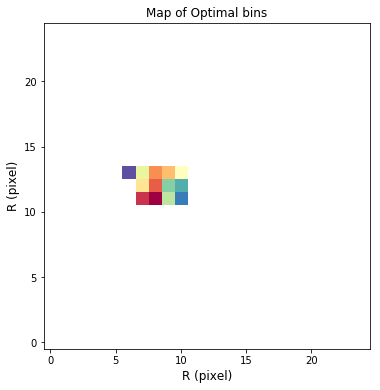

In [22]:
import os
from astropy.io import ascii

gal_list = open('nuc_region_gal.txt','r')
gal_name = gal_list.readlines()
gal_name = list(map(lambda x: x.strip(), gal_name))
gal_list.close()
gal_name = ['ngc5194']
for name in gal_name:
    try:
        exe_bin(name, 'SL1', 1, [5,20], 'Cube_convl', 10)
    except:
        print('Something worry happens!')

In [23]:
def Bin_Spec(name, dirsc, scale, O2):

    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table
    import matplotlib.pyplot as plt
    
    binR = ascii.read('ReProjection/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cube = fits.open('ReProjection/{0}_{1}/{2}/{2}_on2_{3}.fits'.format(dirsc, scale, name, O2))
    cube_u = fits.open('ReProjection/{0}_{1}/{2}/{2}_on2_{3}_unc.fits'.format(dirsc, scale, name, O2))
    flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
    flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    Wave = cube['WCS-TAB'].data[0][0]
    Wave = Wave.sum(axis = 1)
    lee = len(Wave)
    num = np.max(binN)
    for ii in range (1,num+1):
        mask = (binN == ii)
        binRm = binR[mask]
        Spec = np.zeros(lee)
        Spec_u = np.zeros(lee)
        nn = len(binRm)
        for each in binRm:
            Spec = Spec + flux[each['X'], each['Y']]
            Spec_u = Spec_u + flux_u[each['X'], each['Y']]**2
        delt = np.abs(cube[0].header['CDELT1']*cube[0].header['CDELT2'])
        sr = delt*(2*np.pi/360)**2*10**9
        Spec = Spec*sr
        Spec_u = np.sqrt(Spec_u)*sr
#        Spec_u = np.sqrt((np.sqrt(Spec_u)*sr)**2 + (0.1*Spec)**2)
        band = np.zeros(lee, dtype=int)
        Spectra = Table([Wave, Spec, Spec_u, band], names = ('wavelength','flux','sigma','band'))
        Spectra['wavelength'].format = '.8f'
        Spectra['flux'].format = '.8f'
        Spectra['sigma'].format = '.9f'
#                    Spec['band'].format = '6d'
        dirs = 'Spectra/{0}_{1}/{2}/'.format(dirsc, scale, name)
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        Spectra.write('Spectra/{0}_{1}/{2}/{2}_bin_{3}.tbl'.format(dirsc, scale, name, str(ii)),format='ascii.ipac',overwrite=True)
    return ()

def Bin_Phot(name, band, dirsc, scale):

    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table
    
    path = 'Slice/{0}_{1}/{2}/'.format(dirsc, scale, name)
    binR = ascii.read(path + '{0}_binning_output.txt'.format(name), format = 'ipac')
    flux = fits.open(path + '{0}_{1}.fits'.format(name, band))[0].data
    flux = np.transpose(flux, axes=(1, 0))
    flux_u = fits.open(path + '{0}_{1}_unc.fits'.format(name, band))[0].data
    flux_u = np.transpose(flux_u, axes=(1, 0))
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    ind = []
    photo = []
    photo_u = []
    area = []
    header = fits.open(path + '{0}_{1}.fits'.format(name, band))[0].header
    delt = np.abs(header['CDELT1']*header['CDELT2'])
    sr = delt*(2*np.pi/360)**2*10**9
    for ii in range (1,num+1):
        mask = (binN == ii)
        binRm = binR[mask]
        Img = 0
        Unc = 0
        ca = 0
        for each in binRm:
            Img = Img + flux[each['X'], each['Y']]*sr
            Unc = Unc + (flux_u[each['X'], each['Y']]*sr)**2
            ca = ca + cover[each['X'], each['Y']]
        ind.append(ii)
        photo.append(Img)
        photo_u.append(np.sqrt(Unc))
#        photo_u.append(np.sqrt(Unc + (0.1*Img)**2))
        area.append(ca/len(binRm))
    Photom = Table([ind, photo, photo_u, area], names = ('binN','flux', 'sigma', 'area'))
    Photom['flux'].format = '.8f'
    Photom['sigma'].format = '.8f'
    Photom['area'].format = '.3f'
    Photom.write(path + '{0}_{1}_photometry.tbl'.format(name, band), format='ascii.ipac', overwrite=True)
    return ()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    Band_list = ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'MIPS24', 'W1', 'W2', 'W3', 'S7', 'S11', 'L15', 'L24']
    for name in gal_name:
        try:
            Bin_Spec(name, 'Cube_convl', 10, 'SL1')
            print('Spectrometry of {0} is OK!'.format(name))
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name))
        for band in Band_list:
            try:
                Bin_Phot(name, band, 'Cube_convl', 10)
                print('Photometry of {0} {1} image is OK!'.format(name, band))
            except:
                print('Something worry happens when dealing with sample {0}!'.format(name))

Spectrometry of ngc5194 is OK!
Photometry of ngc5194 IRAC1 image is OK!
Photometry of ngc5194 IRAC2 image is OK!
Photometry of ngc5194 IRAC3 image is OK!
Photometry of ngc5194 IRAC4 image is OK!
Photometry of ngc5194 MIPS24 image is OK!
Photometry of ngc5194 W1 image is OK!
Photometry of ngc5194 W2 image is OK!
Photometry of ngc5194 W3 image is OK!
Photometry of ngc5194 S7 image is OK!
Photometry of ngc5194 S11 image is OK!
Photometry of ngc5194 L15 image is OK!
Photometry of ngc5194 L24 image is OK!


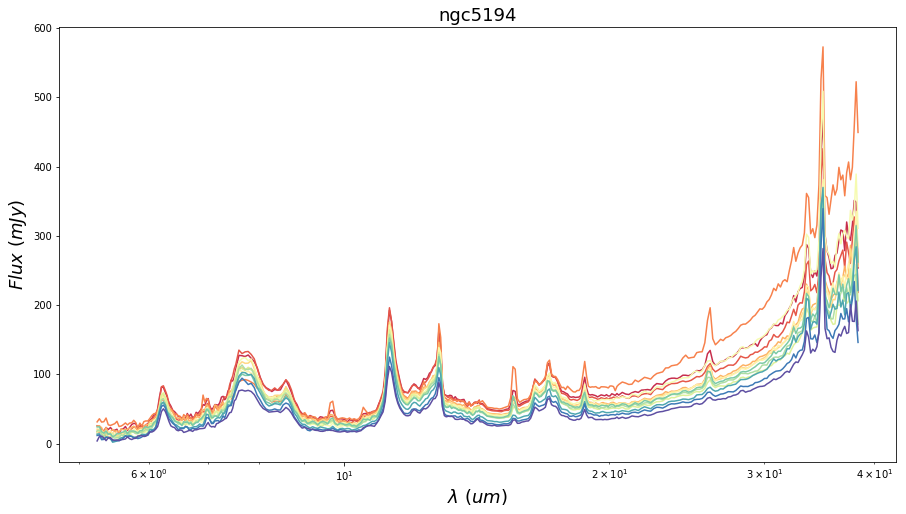

In [24]:
def Plot_bSpec(name, dirsc, scale):

    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    
    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))
    
    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    plt.figure(figsize=[15,8])
    colors = plt.cm.Spectral(np.linspace(0,1,num+1))
    for ii in range(1,num+1):
        if(cover[x[ii-1],y[ii-1]] == 1):
            Spec = ascii.read('Spectra/{0}_{1}/{2}/{2}_bin_{3}.tbl'.format(dirsc, scale, name, ii),format='ipac')
            plt.plot(Spec['wavelength'], Spec['flux'], c = colors[ii])
    plt.xscale('log')
    plt.xlabel('$\lambda\ (um)$', fontsize=18)
    plt.ylabel('$Flux\ (mJy)$', fontsize=18)
    plt.title(name, fontsize=18)
    plt.show()
    return

if __name__ == '__main__':

    gal_file = open('nuc_region_gal.txt')
    gal_name = gal_file.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_name = ['ngc5194']
    for name in gal_name:
        try:
            Plot_bSpec(name, 'Cube_convl', 10)
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name))

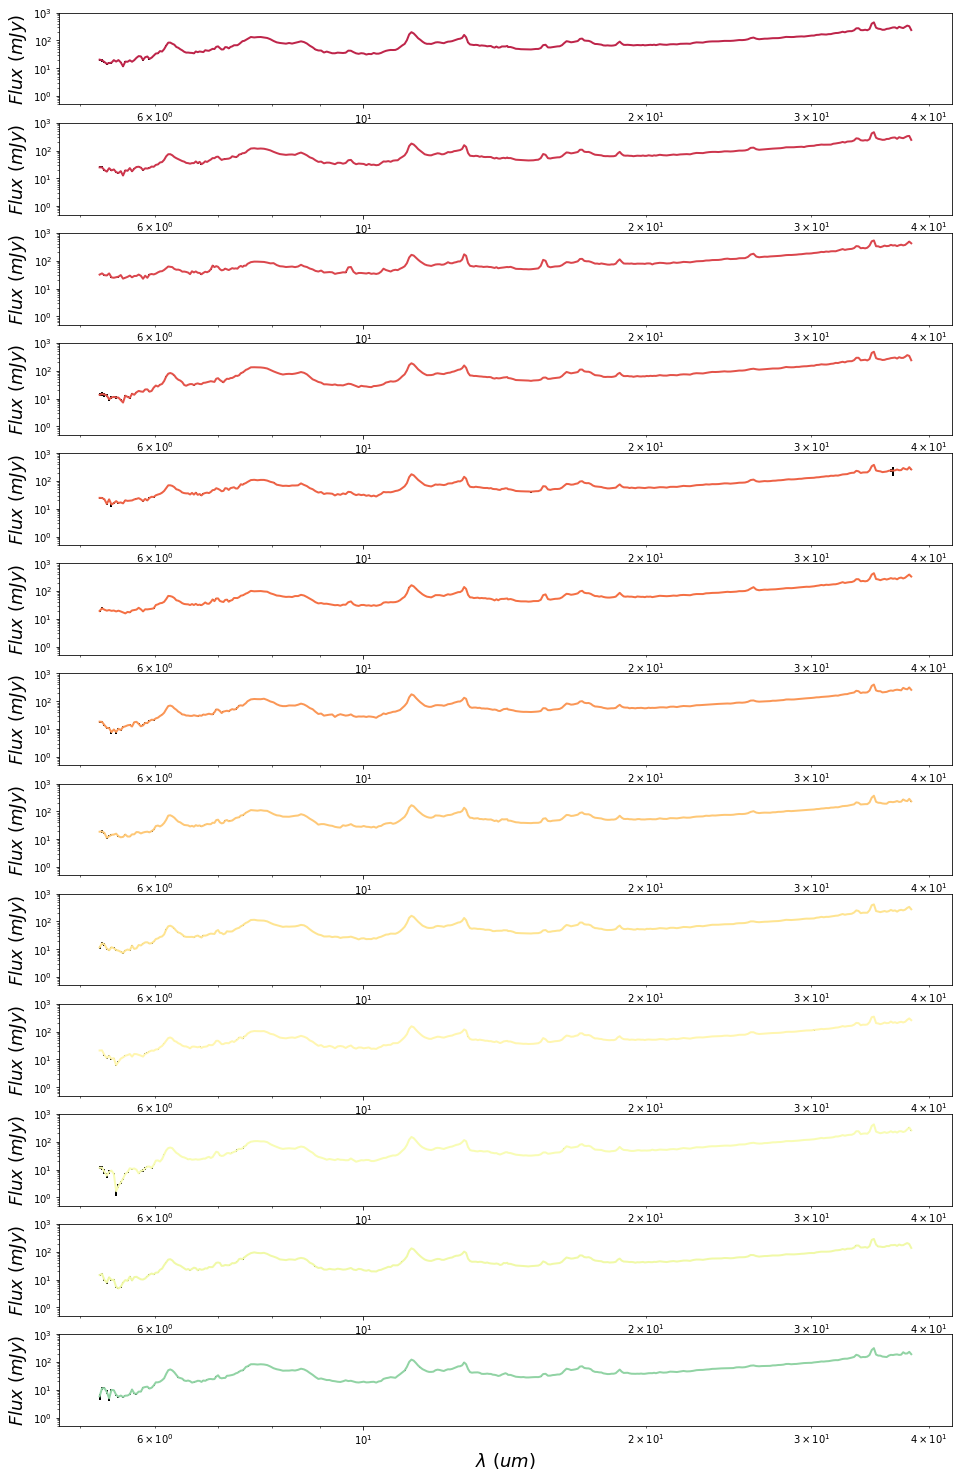

In [5]:
def Plot_bSpec(name, dirsc, scale):

    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    
    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))
    mask = cover==1
    mm = mask.sum()
    
    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    colors = plt.cm.Spectral(np.linspace(0,1,num+1))
    fig, ax = plt.subplots(mm, 1, figsize=(16,2*mm))
    nn = 0
    for ii in range(1,num+1):
        if(cover[x[ii-1],y[ii-1]] == 1):
            Spec = ascii.read('Spectra/{0}_{1}/{2}/{2}_bin_{3}.tbl'.format(dirsc, scale, name, ii),format='ipac')
            ax[nn].errorbar(Spec['wavelength'], Spec['flux'], Spec['sigma'], linewidth = 2., elinewidth=2, color = colors[ii-1], ecolor='k')
            ax[nn].set_xscale('log')
            ax[nn].set_yscale('log')
            ax[nn].set_ylim(0.5,10**3)
            ax[nn].set_ylabel('$Flux\ (mJy)$', fontsize=18)
            nn += 1
    ax[nn-1].set_xlabel('$\lambda\ (um)$', fontsize=18)
#    ax[0].set_title(name.strip(), fontsize=18)
    plt.show()
    return

if __name__ == '__main__':
    gal_name = ['ngc5194']
    for name in gal_name:
        try:
            Plot_bSpec(name, 'Cube_convl', 10)
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name))

In [94]:
def Spc_sed(name, dirsc, scale):
    import os
    import numpy as np
    import astropy.units as u
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
#    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
#    cover = np.transpose(cover, axes=(1, 0))

    band_SL = [['IRAC3', 5.73, 0.1, 'Spitzer_IRAC3'],['S7', 7.0, 0.023, 'IRC_S7'],
               ['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],
               ['W3', 11.56, 0.045, 'WISE_w3']]
    band_LL = [['L15', 15.0, 0.028, 'IRC_L15'], ['L24', 24.0, 0.047, 'IRC_L24'],
               ['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24']]

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    nn = 0
    for each in binN:
        Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, each), format = 'ipac')
        mask = Specc['flux']>0
        Wave = list(Specc['wavelength'][mask])
        Spec = list(Specc['flux'][mask])
        sigma = list(Specc['sigma'][mask])
        band_ind = list(Specc['band'][mask])
        Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
        Spectra['wavelength'].format = '.8f'
        Spectra['flux'].format = '.8f'
        Spectra['sigma'].format = '.9f'
        path = 'Calibration/{0}/Total'.format(name)
        if(os.path.exists(path) == False):
            os.makedirs(path)
        Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, each), format='ascii.ipac', overwrite=True)
            
        ma1 = Specc['flux']>0
        ma2 = Specc['wavelength'] < 14.2666
        mask = ma1*ma2
        Wave = list(Specc['wavelength'][mask])
        Spec = list(Specc['flux'][mask])
        sigma = list(Specc['sigma'][mask])
        band_ind = list(Specc['band'][mask])
        for band in band_LL:
            Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
            ma = Phot['binN']==each
            Phof = Phot[ma]['flux']
            Phou = Phot[ma]['sigma']
            Wave.append(band[1])
            Spec.append(Phof)
            sigma.append(Phou)
            band_ind.append(band[3])
        Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
        Spectra['wavelength'].format = '.8f'
        Spectra['flux'].format = '.8f'
        Spectra['sigma'].format = '.9f'
        path = 'Calibration/{0}/Only_SL'.format(name)
        if(os.path.exists(path) == False):
            os.makedirs(path)
        Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, each),format='ascii.ipac',overwrite=True)
            
        ma1 = Specc['flux']>0
        ma2 = Specc['wavelength'] >= 14.2666
        mask = ma1*ma2
        Wave = list(Specc['wavelength'][mask])
        Spec = list(Specc['flux'][mask])
        sigma = list(Specc['sigma'][mask])
        band_ind = list(Specc['band'][mask])
        for band in band_SL:
            Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
            ma = Phot['binN']==each
            Phof = Phot[ma]['flux']
            Phou = Phot[ma]['sigma']
            Wave.append(band[1])
            Spec.append(Phof)
            sigma.append(Phou)
            band_ind.append(band[3])
        Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
        Spectra['wavelength'].format = '.8f'
        Spectra['flux'].format = '.8f'
        Spectra['sigma'].format = '.9f'
        path = 'Calibration/{0}/Only_LL'.format(name)
        if(os.path.exists(path) == False):
            os.makedirs(path)
        Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, each),format='ascii.ipac',overwrite=True)
    return()

if __name__ == '__main__':

    gal_name = ['ngc5194']
    for name in gal_name:
        try:
            Spc_sed(name, 'Cube_convl', 10)
            print('SED is OK!'.format(name, band[0]))
        except:
            print('Something wrong happens when dealing with sample {0}!'.format(name))

SED is OK!


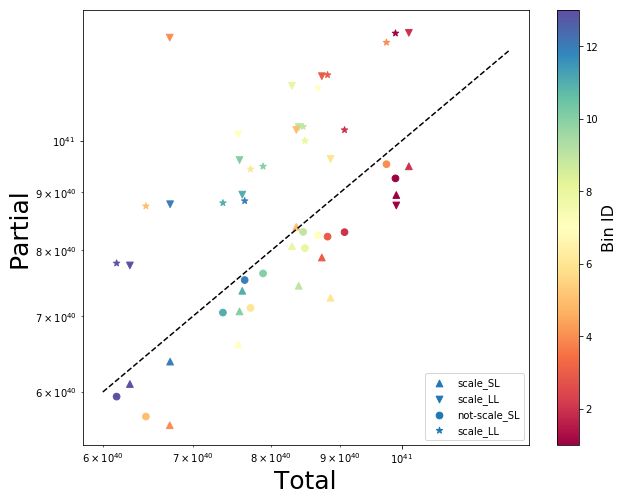

In [8]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

def Plot(num, mode, mk, label):

    path = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(num)
#    path2 = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(51)
    fitrs1 = ascii.read('{0}/Total.ipac'.format(path), format='ipac')
    fitrs2 = ascii.read('{0}/Only{1}.ipac'.format(path, mode), format='ipac')
    name_t = fitrs1['Name']
    name_p = fitrs2['Name']
    color = []
    total = []
    partial = []
    for each in fitrs1:
        mask = name_p==each['Name']
        color.append(float(each['Name'].split('_')[-1]))
        total.append(each['Lpah_tmp_C'])
        partial.append(fitrs2[mask]['Lpah_tmp_C'][0])
    color = np.array(color)
    Vari = ax.scatter(total, partial, c = color, marker=mk, cmap='Spectral', s=45, label=label+'_{0}'.format(mode))
#    cbar = f.colorbar(Vari)
#    cbar.ax.set_ylabel('Bin ID',fontsize=16)
#    ax.invert_xaxis()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Total',fontsize=25)
    ax.set_ylabel('Partial',fontsize=25)
    ax.legend(loc=4)
#    ax.set_ylabel('Only{0}'.format(mode),fontsize=25)
    return(Vari)

if __name__ == '__main__':

    mode = ['SL', 'LL']
    f, ax = plt.subplots(1, 1, figsize=[10,8])
    Plot(50, 'SL', '^', 'scale')
    Plot(50, 'LL', 'v', 'scale')
    Plot(51, 'SL', 'o', 'not-scale')
    Vari = Plot(51, 'LL', '*', 'scale')
    xx = np.arange(6e40,1.2e41,1e39)
    ax.plot(xx, xx, 'k--')
    cbar = f.colorbar(Vari)
    cbar.ax.set_ylabel('Bin ID',fontsize=16)
    plt.show()

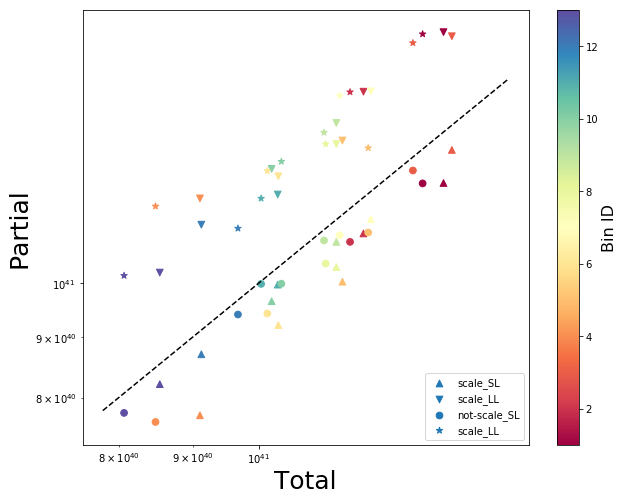

In [10]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

def Plot(num, mode, mk, label):

    path = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(num)
#    path2 = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(51)
    fitrs1 = ascii.read('{0}/Total.ipac'.format(path), format='ipac')
    fitrs2 = ascii.read('{0}/Only{1}.ipac'.format(path, mode), format='ipac')
    name_t = fitrs1['Name']
    name_p = fitrs2['Name']
    color = []
    total = []
    partial = []
    for each in fitrs1:
        mask = name_p==each['Name']
        color.append(float(each['Name'].split('_')[-1]))
        total.append(each['Lpah_tmp_C'])
        partial.append(fitrs2[mask]['Lpah_tmp_C'][0])
    color = np.array(color)
    Vari = ax.scatter(total, partial, c = color, marker=mk, cmap='Spectral', s=45, label=label+'_{0}'.format(mode))
#    cbar = f.colorbar(Vari)
#    cbar.ax.set_ylabel('Bin ID',fontsize=16)
#    ax.invert_xaxis()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Total',fontsize=25)
    ax.set_ylabel('Partial',fontsize=25)
    ax.legend(loc=4)
#    ax.set_ylabel('Only{0}'.format(mode),fontsize=25)
    return(Vari)

if __name__ == '__main__':

    mode = ['SL', 'LL']
    f, ax = plt.subplots(1, 1, figsize=[10,8])
    Plot(60, 'SL', '^', 'scale')
    Plot(60, 'LL', 'v', 'scale')
    Plot(61, 'SL', 'o', 'not-scale')
    Vari = Plot(61, 'LL', '*', 'scale')
    xx = np.arange(7.8e40,1.5e41,1e39)
    ax.plot(xx, xx, 'k--')
    cbar = f.colorbar(Vari)
    cbar.ax.set_ylabel('Bin ID',fontsize=16)
    plt.show()

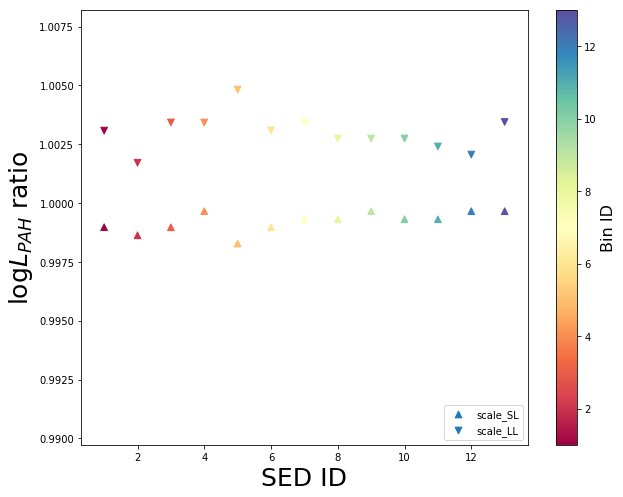

In [140]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

def Plot(num, mode, mk, label):

    path = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(num)
#    path2 = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(51)
    fitrs1 = ascii.read('{0}/Total.ipac'.format(path), format='ipac')
    fitrs2 = ascii.read('{0}/Only{1}.ipac'.format(path, mode), format='ipac')
    name_t = fitrs1['Name']
    name_p = fitrs2['Name']
    color = []
    total = []
    partial = []
    for each in fitrs1:
        mask = name_p==each['Name']
        color.append(float(each['Name'].split('_')[-1]))
        total.append(float(each['Name'].split('_')[-1]))
        partial.append(fitrs2[mask]['logLpah_C'][0]/each['logLpah_C'])
    color = np.array(color)
    Vari = ax.scatter(total, partial, c = color, marker=mk, cmap='Spectral', s=45, label=label+'_{0}'.format(mode))
#    cbar = f.colorbar(Vari)
#    cbar.ax.set_ylabel('Bin ID',fontsize=16)
#    ax.invert_xaxis()
#    ax.set_xscale('log')
#    ax.set_yscale('log')
    ax.set_xlabel('SED ID',fontsize=25)
    ax.set_ylabel('log$L_{PAH}$ ratio',fontsize=25)
    ax.legend(loc=4)
#    ax.set_ylabel('Only{0}'.format(mode),fontsize=25)
    return(Vari)

if __name__ == '__main__':

    mode = ['SL', 'LL']
    f, ax = plt.subplots(1, 1, figsize=[10,8])
    Plot(51, 'SL', '^', 'scale')
    Plot(51, 'LL', 'v', 'scale')
#    Plot(51, 'SL', 'o', 'not-scale')
#    Plot(51, 'LL', '*', 'scale')
#    xx = np.arange(29,29.5,0.01)
#    ax.plot(xx, xx, 'k--')
    cbar = f.colorbar(Vari)
    cbar.ax.set_ylabel('Bin ID',fontsize=16)
    plt.show()

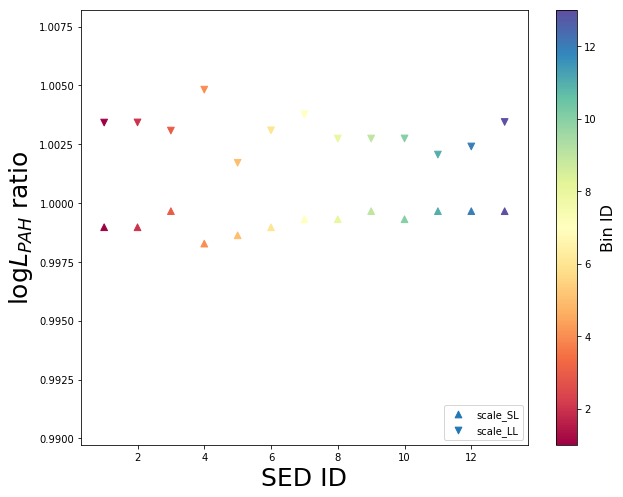

In [11]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

def Plot(num, mode, mk, label):

    path = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(num)
#    path2 = '/Users/zhangl/Desktop/Montage/miniProject/underworld/Draft/Fit_R/Fit_Result{0}'.format(51)
    fitrs1 = ascii.read('{0}/Total.ipac'.format(path), format='ipac')
    fitrs2 = ascii.read('{0}/Only{1}.ipac'.format(path, mode), format='ipac')
    name_t = fitrs1['Name']
    name_p = fitrs2['Name']
    color = []
    total = []
    partial = []
    for each in fitrs1:
        mask = name_p==each['Name']
        color.append(float(each['Name'].split('_')[-1]))
        total.append(float(each['Name'].split('_')[-1]))
        partial.append(fitrs2[mask]['logLpah_C'][0]/each['logLpah_C'])
    color = np.array(color)
    Vari = ax.scatter(total, partial, c = color, marker=mk, cmap='Spectral', s=45, label=label+'_{0}'.format(mode))
#    cbar = f.colorbar(Vari)
#    cbar.ax.set_ylabel('Bin ID',fontsize=16)
#    ax.invert_xaxis()
#    ax.set_xscale('log')
#    ax.set_yscale('log')
    ax.set_xlabel('SED ID',fontsize=25)
    ax.set_ylabel('log$L_{PAH}$ ratio',fontsize=25)
    ax.legend(loc=4)
#    ax.set_ylabel('Only{0}'.format(mode),fontsize=25)
    return(Vari)

if __name__ == '__main__':

    mode = ['SL', 'LL']
    f, ax = plt.subplots(1, 1, figsize=[10,8])
    Plot(61, 'SL', '^', 'scale')
    Plot(61, 'LL', 'v', 'scale')
#    Plot(51, 'SL', 'o', 'not-scale')
#    Plot(51, 'LL', '*', 'scale')
#    xx = np.arange(29,29.5,0.01)
#    ax.plot(xx, xx, 'k--')
    cbar = f.colorbar(Vari)
    cbar.ax.set_ylabel('Bin ID',fontsize=16)
    plt.show()

In [ ]:
def Syn_sed(name, dirsc, scale):
    import os
    import numpy as np
    import astropy.units as u
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    band_SL = [['IRAC3', 5.73, 0.1, 'Spitzer_IRAC3'],['S7', 7.0, 0.023, 'IRC_S7'],
               ['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],
               ['W3', 11.56, 0.045, 'WISE_w3']]
    band_LL = [['L15', 15.0, 0.028, 'IRC_L15'], ['L24', 24.0, 0.047, 'IRC_L24'],
               ['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24']]

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    nn = 0
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            nn += 1
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = list(Specc['wavelength'][mask])
            Spec = list(Specc['flux'][mask])
            sigma = list(Specc['sigma'][mask])
            band_ind = list(Specc['band'][mask])
            Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
            Spectra['wavelength'].format = '.8f'
            Spectra['flux'].format = '.8f'
            Spectra['sigma'].format = '.9f'
            path = 'Calibration/{0}/Total'.format(name)
            if(os.path.exists(path) == False):
                os.makedirs(path)
            Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, nn), format='ascii.ipac', overwrite=True)
            
            ma1 = Specc['flux']>0
            ma2 = Specc['wavelength'] < 14.2666
            mask = ma1*ma2
            Wave = list(Specc['wavelength'][mask])
            Spec = list(Specc['flux'][mask])
            sigma = list(Specc['sigma'][mask])
            band_ind = list(Specc['band'][mask])
            for band in band_LL:
                Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
                ma = Phot['binN']==binN[ii]
                Phof = Phot[ma]['flux']
                Phou = Phot[ma]['sigma']
                Wave.append(band[1])
                Spec.append(Phof)
                sigma.append(Phou)
                band_ind.append(band[3])
            Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
            Spectra['wavelength'].format = '.8f'
            Spectra['flux'].format = '.8f'
            Spectra['sigma'].format = '.9f'
            path = 'Calibration/{0}/Only_SL'.format(name)
            if(os.path.exists(path) == False):
                os.makedirs(path)
            Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, nn),format='ascii.ipac',overwrite=True)
            
            ma1 = Specc['flux']>0
            ma2 = Specc['wavelength'] >= 14.2666
            mask = ma1*ma2
            Wave = list(Specc['wavelength'][mask])
            Spec = list(Specc['flux'][mask])
            sigma = list(Specc['sigma'][mask])
            band_ind = list(Specc['band'][mask])
            for band in band_SL:
                Phof = Photometry(Specc['wavelength'], Specc['flux'], band[3])
                Phou = band[2]*Phof
                Wave.append(band[1])
                Spec.append(Phof)
                sigma.append(Phou)
                band_ind.append(band[3])
            Spectra = Table([Wave*u.um, Spec*u.mJy, sigma*u.mJy, band_ind], names = ('wavelength','flux','sigma','band'))
            Spectra['wavelength'].format = '.8f'
            Spectra['flux'].format = '.8f'
            Spectra['sigma'].format = '.9f'
            path = 'Calibration/{0}/Only_LL'.format(name)
            if(os.path.exists(path) == False):
                os.makedirs(path)
            Spectra.write('{0}/ngc5194_sed_{1}.tbl'.format(path, nn),format='ascii.ipac',overwrite=True)
    return()

if __name__ == '__main__':

    gal_name = ['ngc5194']
    for name in gal_name:
        try:
            Syn_sed(name, 'Cube_convl', 10)
            print('SED is OK!')
        except:
            print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube & Non-Scale

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


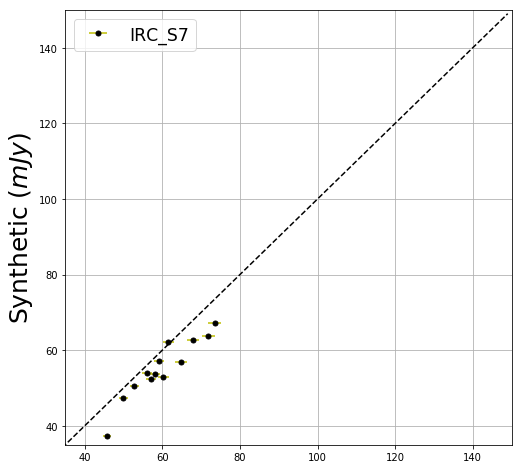

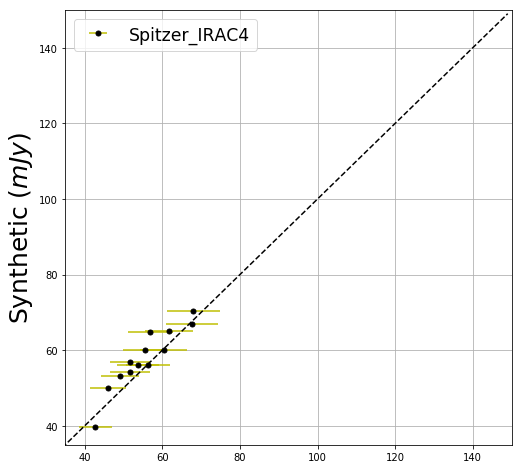

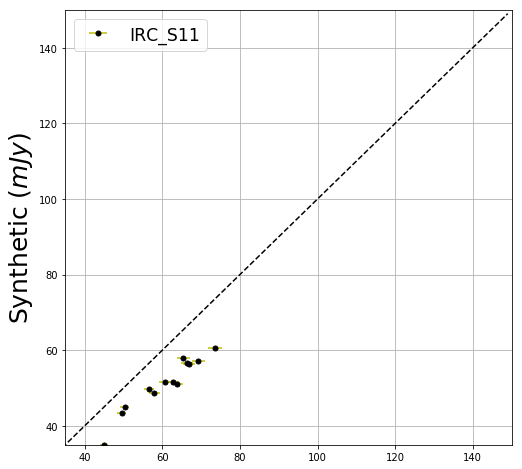

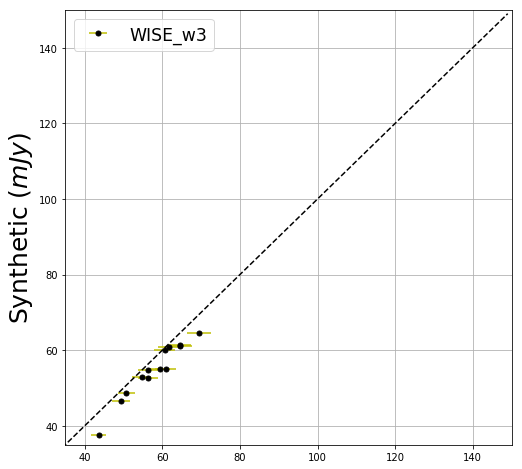

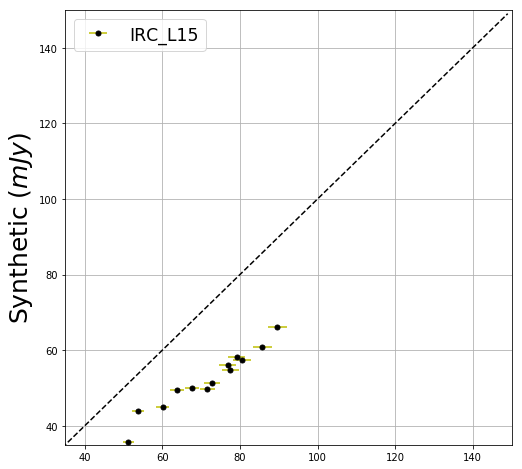

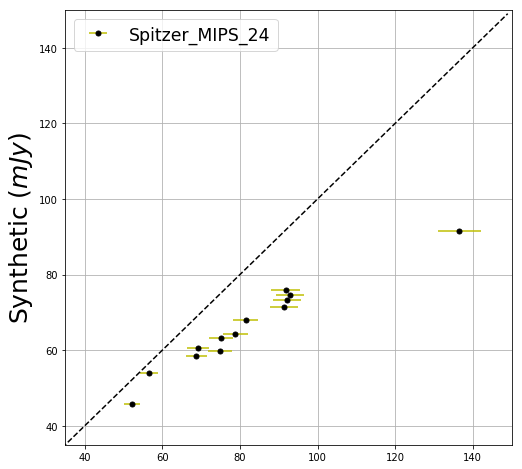

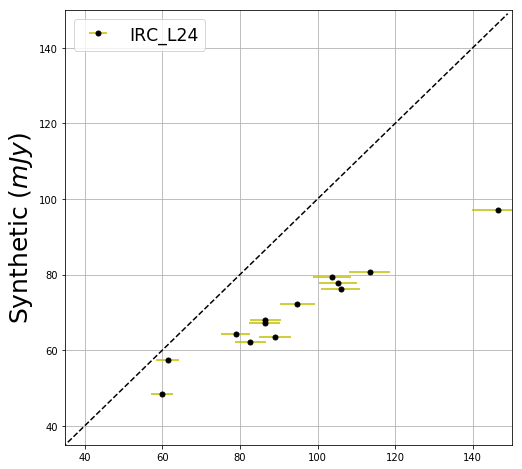

In [9]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[1], array[0], xerr = array[2], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube & Non-Scale, aperture correction applied

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


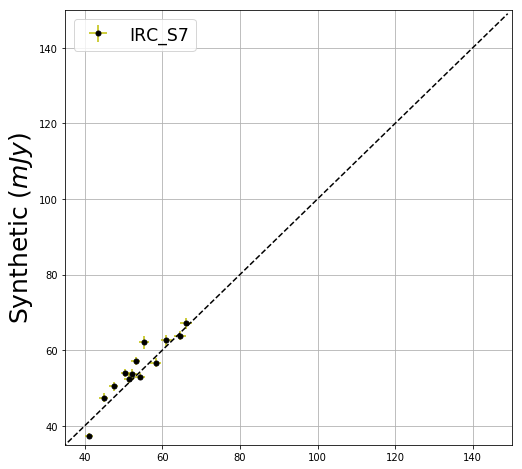

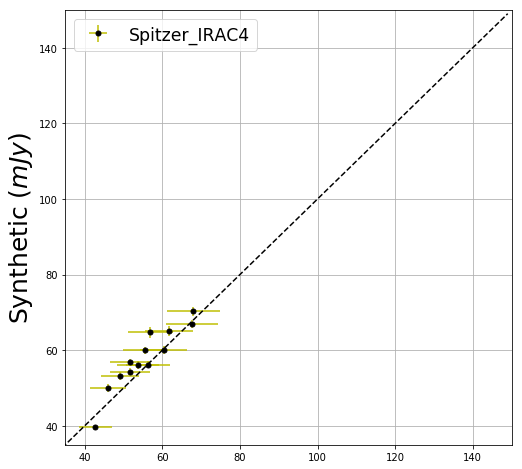

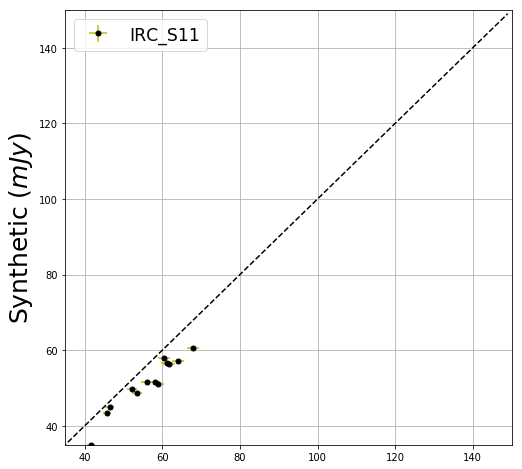

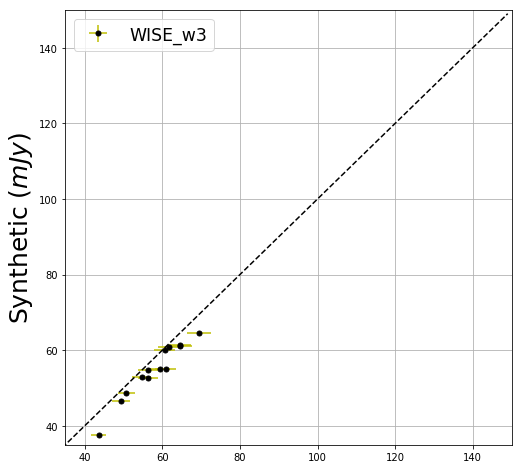

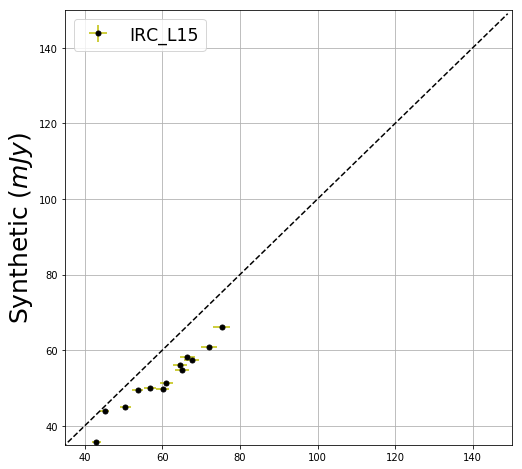

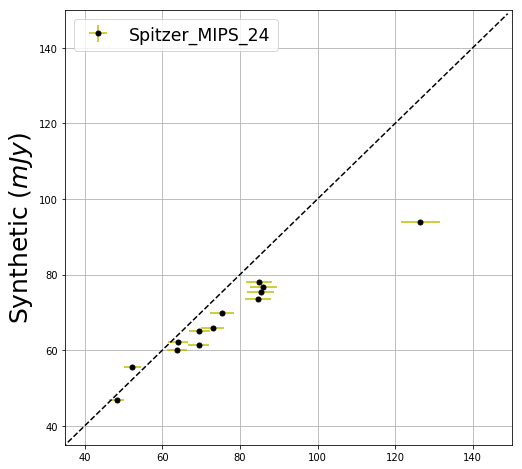

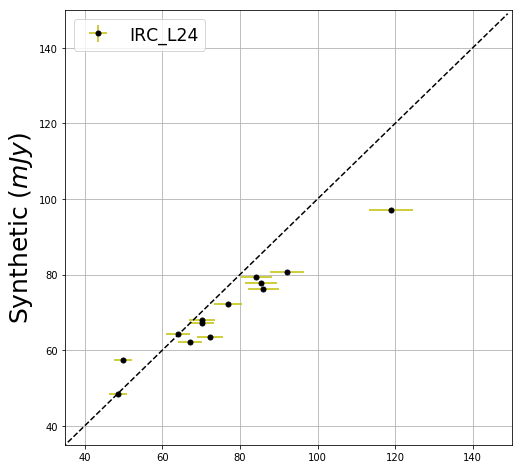

In [8]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    SynUnc = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            sigma = Specc['sigma'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            SynUncc = Photometry_unc(Wave, sigma, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
            SynUnc.append(SynUncc)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    SynUnc = np.array(SynUnc)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(SynUnc[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
        array[3].append(arr[ii][3])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[2], array[0], xerr = array[3], yerr=array[1], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube & Scale, aperture correction applied

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


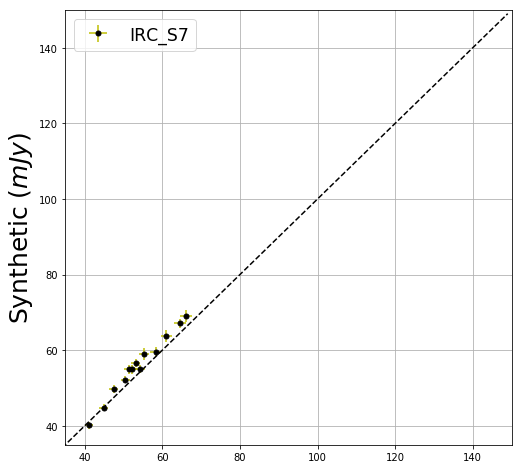

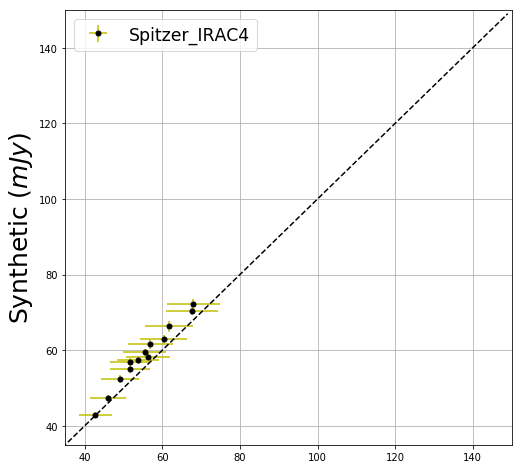

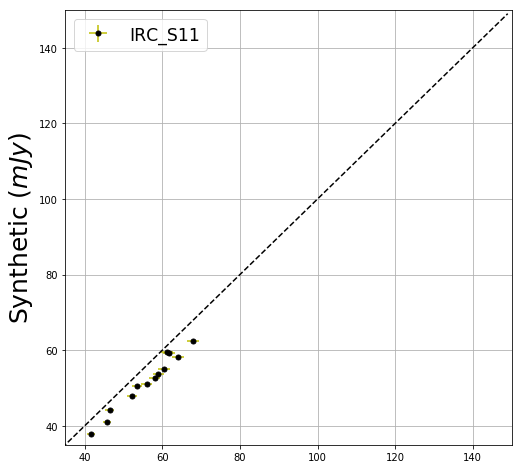

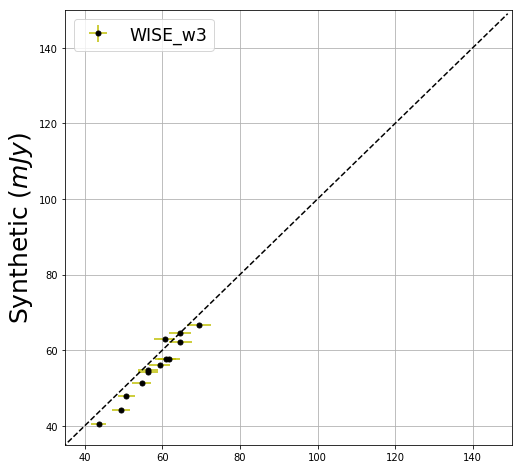

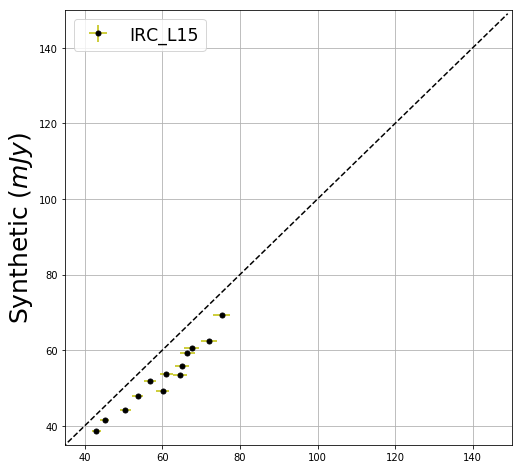

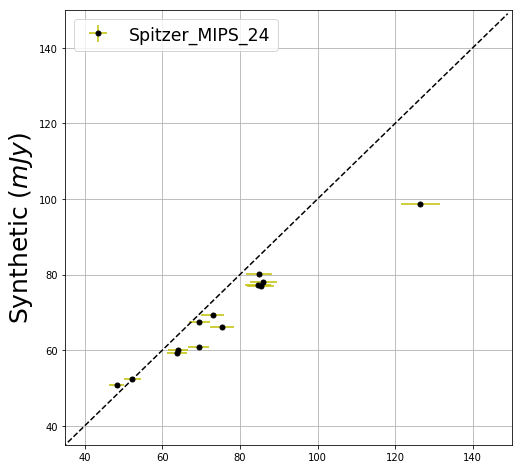

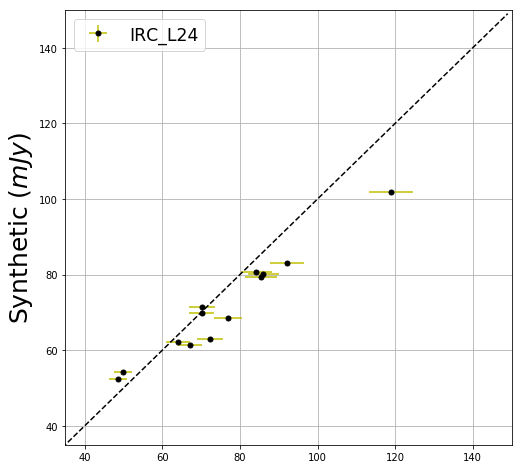

In [21]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    SynUnc = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            sigma = Specc['sigma'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            SynUncc = Photometry_unc(Wave, sigma, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
            SynUnc.append(SynUncc)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    SynUnc = np.array(SynUnc)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(SynUnc[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
        array[3].append(arr[ii][3])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[2], array[0], xerr = array[3], yerr=array[1], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube & Scale

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


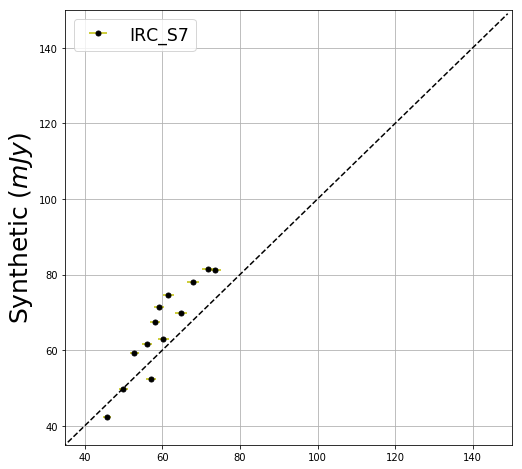

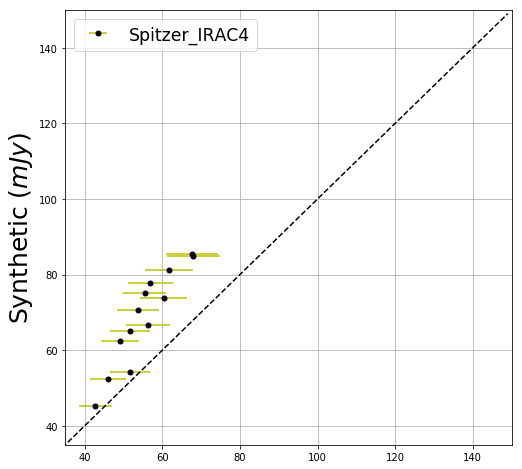

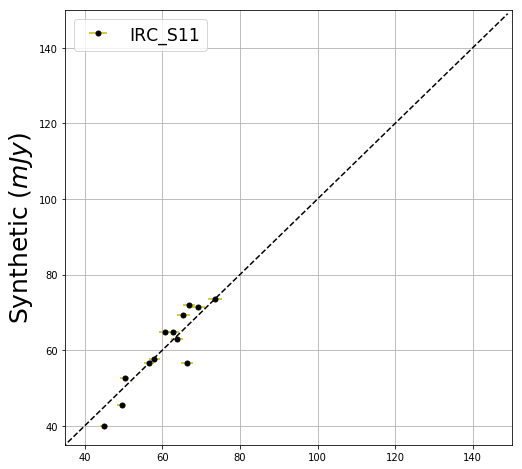

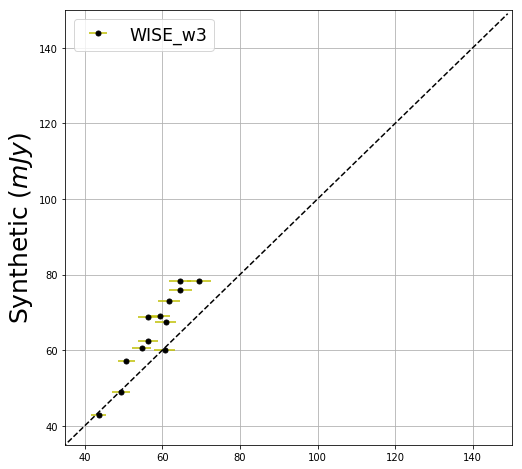

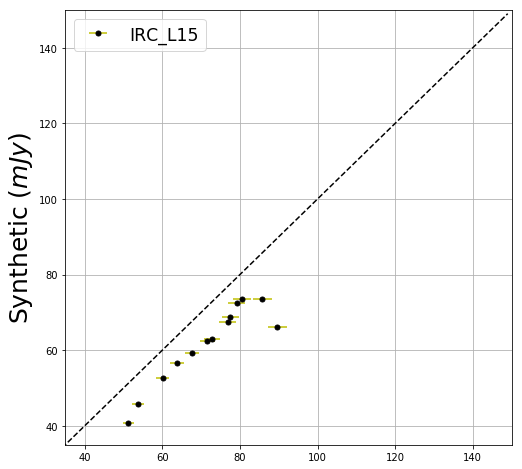

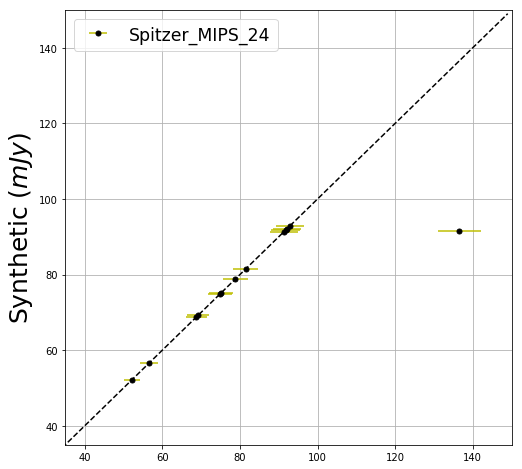

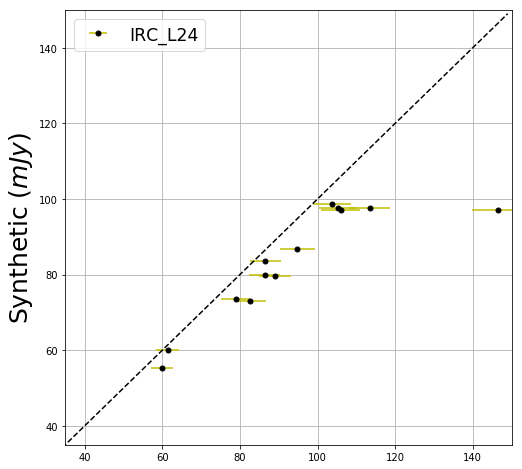

In [55]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[1], array[0], xerr = array[2], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube-Colvl & Non-Scale, aperture correction applied

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


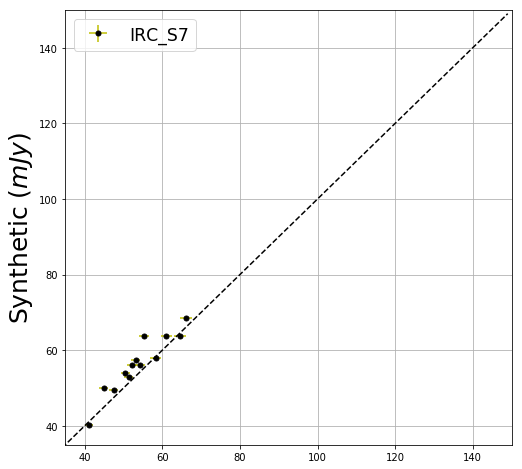

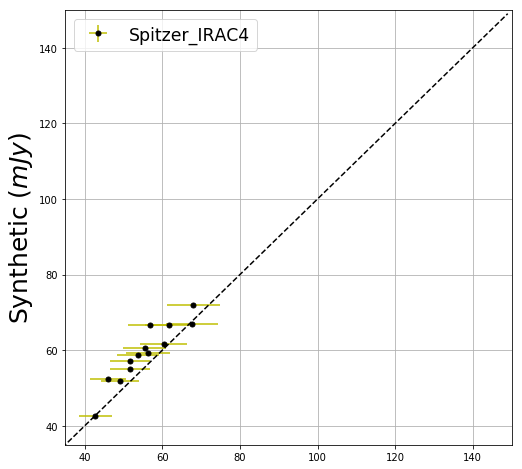

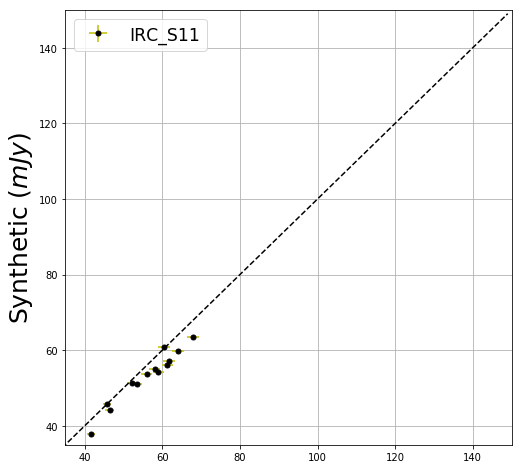

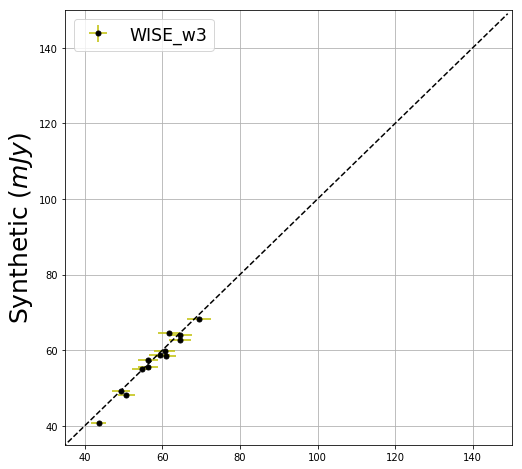

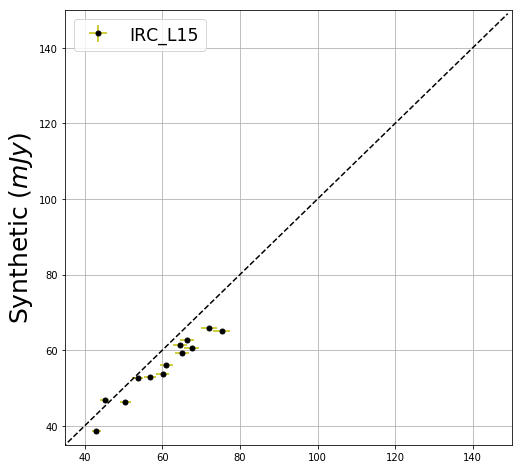

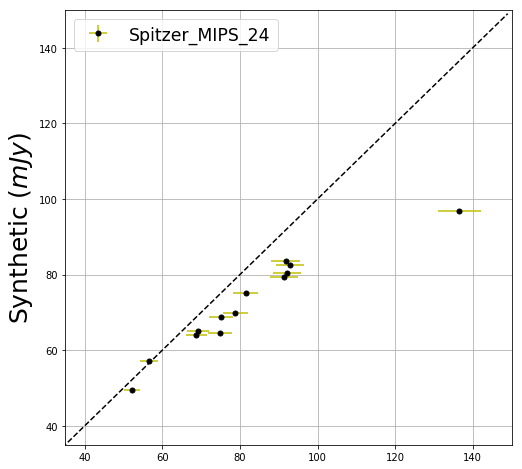

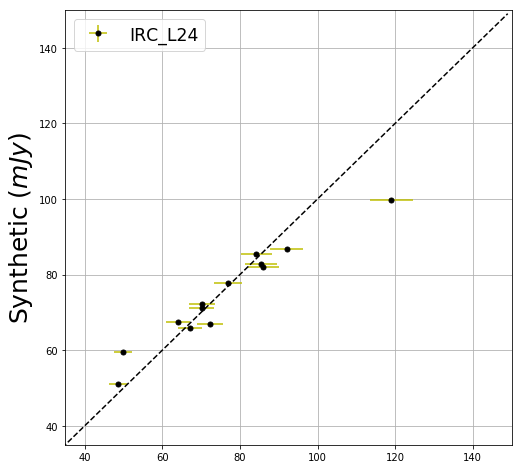

In [11]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    SynUnc = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            sigma = Specc['sigma'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            SynUncc = Photometry_unc(Wave, sigma, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
            SynUnc.append(SynUncc)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    SynUnc = np.array(SynUnc)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(SynUnc[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
        array[3].append(arr[ii][3])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[2], array[0], xerr = array[3], yerr=array[1], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube-Colvl & Scale

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


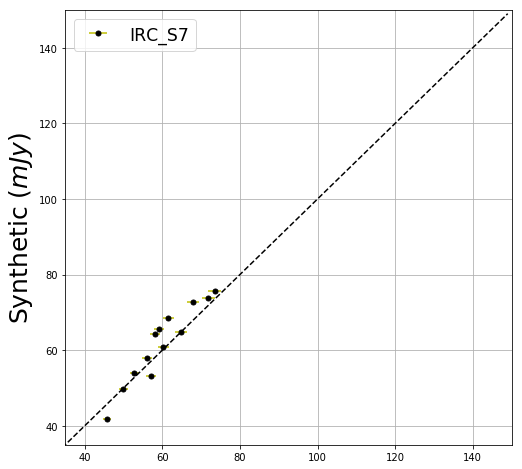

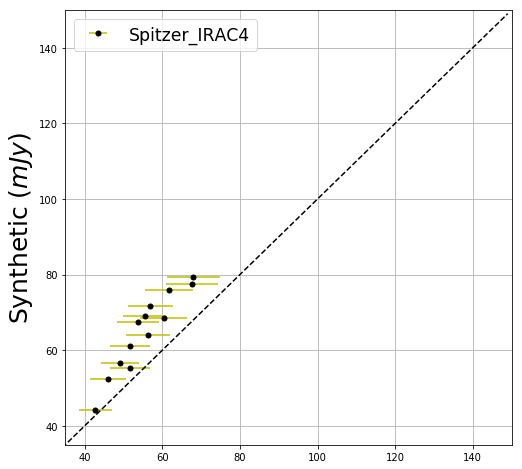

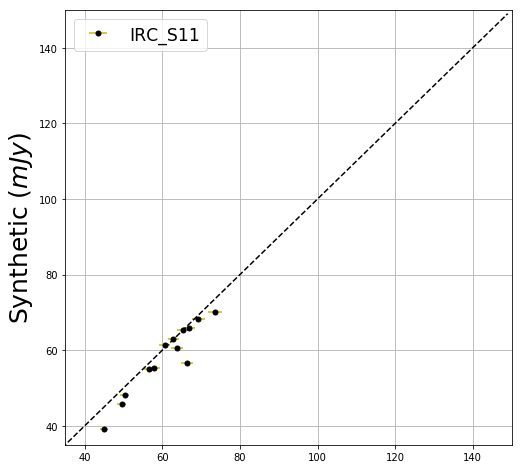

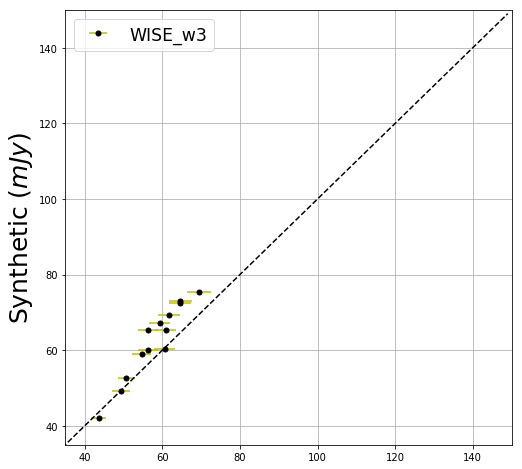

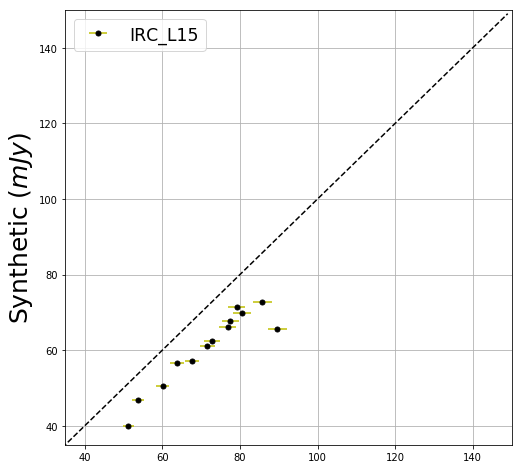

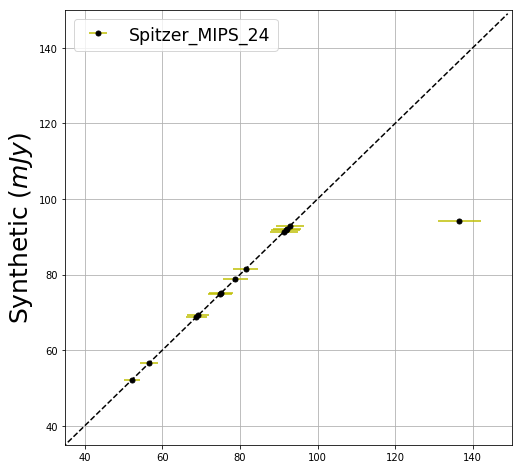

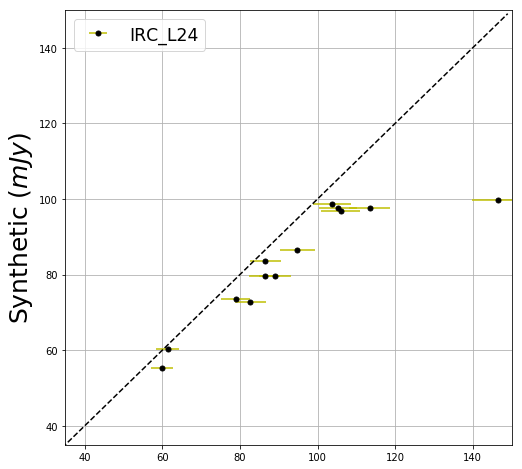

In [42]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[1], array[0], xerr = array[2], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

### Cube-Colvl & Scale, aperture correction applied

Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!
Confirmation is OK!


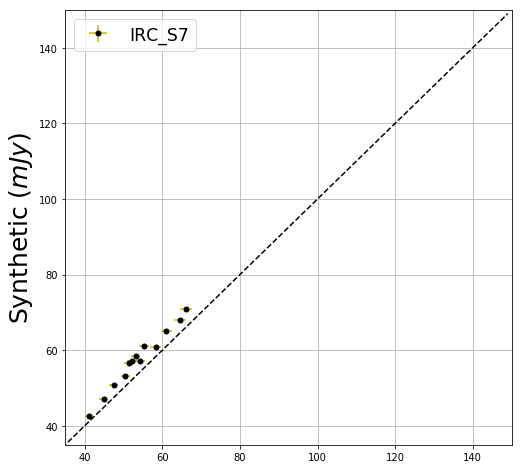

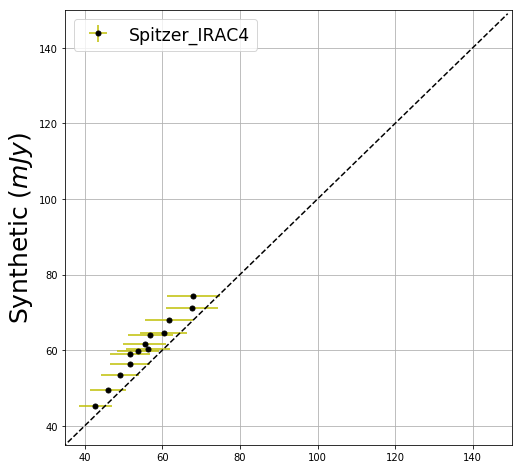

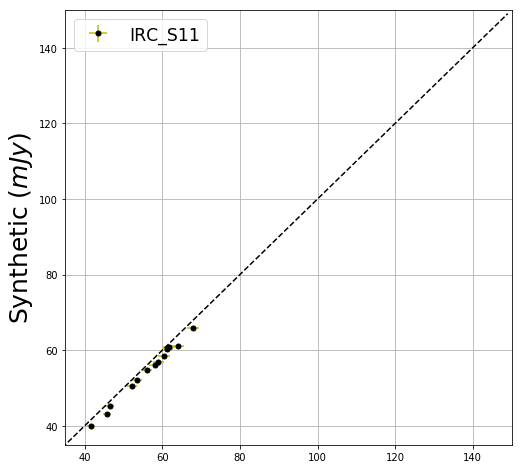

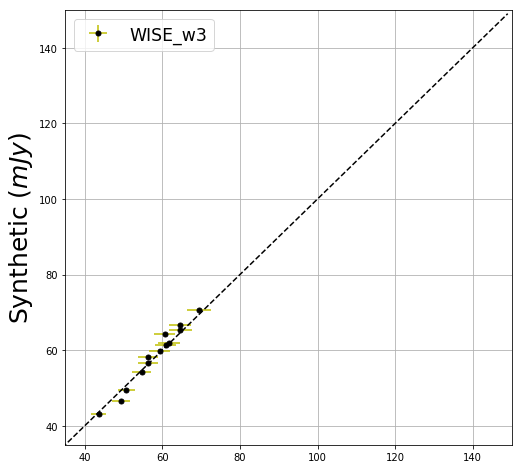

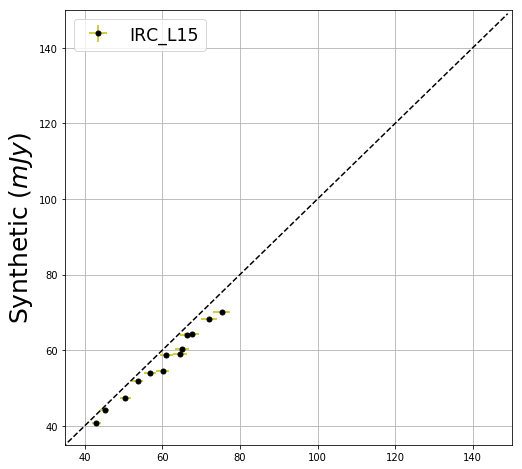

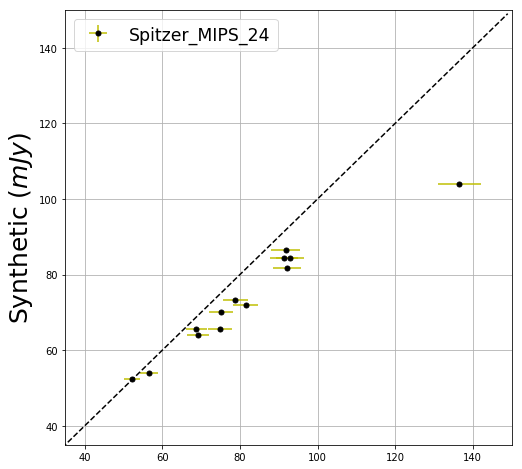

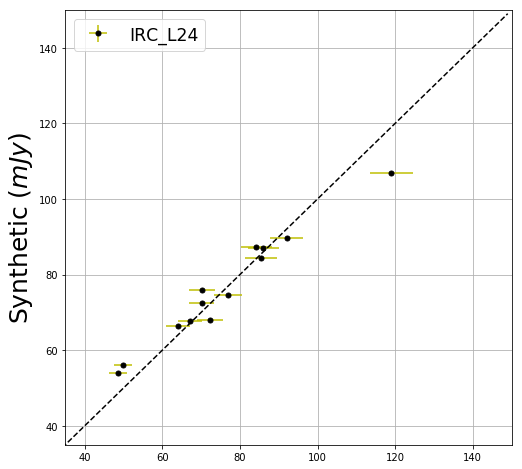

In [18]:
def Cal_confirmation(name, dirsc, scale, band):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    binR = ascii.read('Slice/{0}_{1}/{2}/{2}_binning_output.txt'.format(dirsc, scale, name), format = 'ipac')
    cover = fits.open('Slice/{0}_{1}/{2}/indice.fits'.format(dirsc, scale, name))[0].data
    cover = np.transpose(cover, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    Phot = ascii.read('Slice/{0}_{1}/{2}/{2}_{3}_photometry.tbl'.format(dirsc, scale, name, band[0]), format = 'ipac')
    ObsPhot = []
    ObsUnc = []
    SynPhot = []
    SynUnc = []
    for ii in range(0,num):
        if(cover[x[ii],y[ii]] == 1):
            Specc = ascii.read('Spectra/{0}_{1}/{2}/ngc5194_bin_{3}.tbl'.format(dirsc, scale, name, binN[ii]), format = 'ipac')
            mask = Specc['flux']>0
            Wave = Specc['wavelength'][mask]
            Spec = Specc['flux'][mask]
            sigma = Specc['sigma'][mask]
            ma = Phot['binN']==binN[ii]
            ObsPhott = Phot[ma]['flux']
            ObsUncc = Phot[ma]['sigma']
            SynPhott = Photometry(Wave, Spec, band[3])
            SynUncc = Photometry_unc(Wave, sigma, band[3])
            ObsPhot.append(ObsPhott)
            ObsUnc.append(ObsUncc)
            SynPhot.append(SynPhott)
            SynUnc.append(SynUncc)
    ObsPhot = np.array(ObsPhot)
    ObsUnc = np.array(ObsUnc)
    SynPhot = np.array(SynPhot)
    SynUnc = np.array(SynUnc)
    arr = []
    for ii in range(len(ObsPhot)):
        arrr = []
        arrr.append(SynPhot[ii])
        arrr.append(SynUnc[ii])
        arrr.append(ObsPhot[ii])
        arrr.append(ObsUnc[ii])
        arr.append(arrr)
    arr = sorted(arr, key=lambda x: x[0])
    array = [[],[],[],[]]
    for ii in range(len(arr)):
        array[0].append(arr[ii][0])
        array[1].append(arr[ii][1])
        array[2].append(arr[ii][2])
        array[3].append(arr[ii][3])
    f, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.errorbar(array[2], array[0], xerr = array[3], yerr=array[1], c='k', ecolor='y', marker='.', markersize=10, linestyle='', label='{0}'.format(band[3]))
    xx = np.arange(0,150,1)
    ax.plot(xx, xx, 'k--')
    ax.set_xlim(35, 150)
    ax.set_ylim(35, 150)
    ax.set_ylabel('Synthetic $(mJy)$',fontsize=25)
    ax.legend(fontsize='xx-large')
    ax.grid(True)
    return()

if __name__ == '__main__':

    gal_list = open('nuc_region_gal.txt','r')
    gal_name = gal_list.readlines()
    gal_name = list(map(lambda x: x.strip(), gal_name))
    gal_list.close()
    gal_name = ['ngc5194']
    band_list = [['S7', 7.0, 0.023, 'IRC_S7'],['IRAC4', 7.87, 0.1, 'Spitzer_IRAC4'],['S11', 11.0, 0.024, 'IRC_S11'],['W3', 11.56, 0.045, 'WISE_w3'],
                 ['L15', 15.0, 0.028, 'IRC_L15'],['MIPS24', 23.68, 0.04, 'Spitzer_MIPS_24'],['L24', 24.0, 0.047, 'IRC_L24']]
    for name in gal_name:
        for band in band_list:
            try:
                Cal_confirmation(name, 'Cube_convl', 10, band)
                print('Confirmation is OK!'.format(name, band[0]))
            except:
                print('Something wrong happens when dealing with sample {0}!'.format(name))

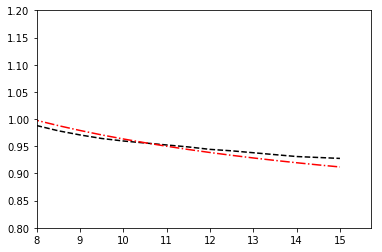

In [113]:
import numpy as np
import matplotlib.pyplot as plt

sa = np.arange(0.5,15.5,0.5)
sa = sa
af = np.array([0.046,0.157,0.308,0.434,0.531,0.589,0.635,0.685,0.747,0.814,0.878,0.926,0.961,0.984,1.000,
               1.012,1.022,1.030,1.037,1.042,1.046,1.050,1.054,1.059,1.062,1.066,1.070,1.074,1.076,1.078])
plt.plot(sa, 1/af, 'k--')
taf = 1.764*np.exp(-sa**0.396) +0.817
plt.plot(sa, taf, 'r-.')
plt.xlim(8,)
plt.ylim(0.8,1.2)
plt.show()

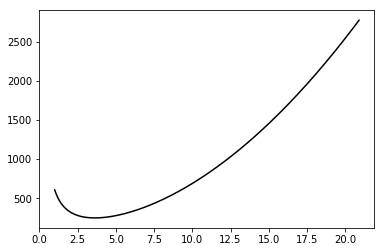

In [39]:
import matplotlib.pyplot as plt

r = np.arange(1,21,0.1)
S = 2*np.pi*r**2 + 600/r
plt.plot(r, S, 'k')
plt.show()

0.9741004887144994 1.0461700975977215
0.974100488957429 1.0461700977311246
0.9741004893512161 1.0461700978708546


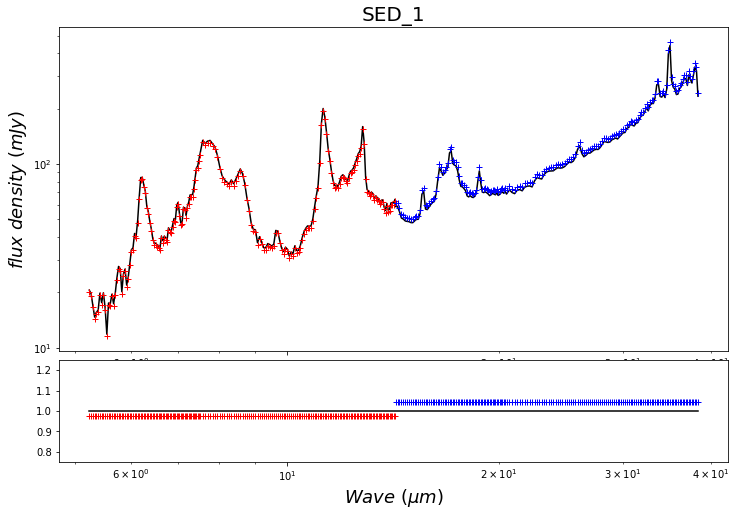

0.9809043543801078 1.0354929149591816
0.980904354683792 1.0354929150904748
0.9809043550520712 1.0354929152252659


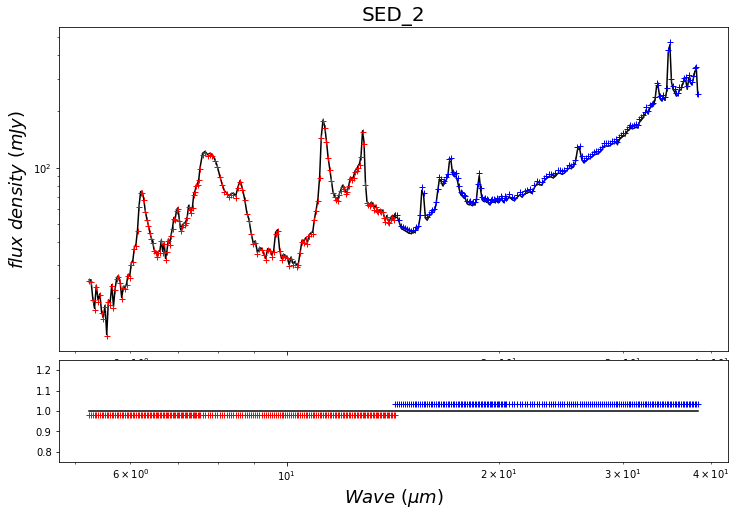

0.9795950511797367 1.038406540500192
0.9795950517685246 1.0384065406260747
0.979595052283052 1.038406540785955


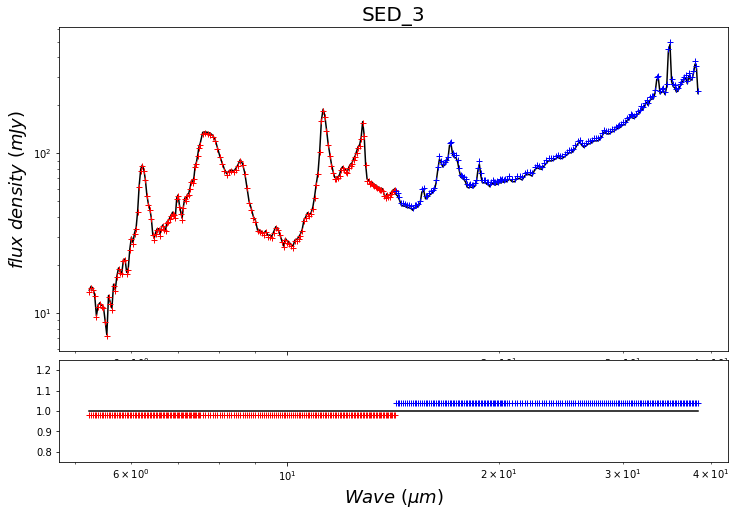

0.9498753078880647 1.2123691039987745
0.9498753082055101 1.2123691041230362
0.949875308526297 1.212369104272614


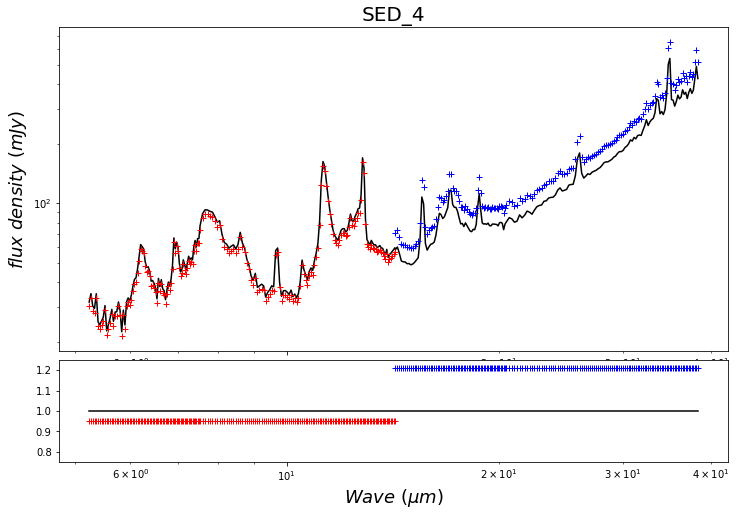

0.956508659183651 1.0854435947016843
0.9565086596148228 1.085443594915898
0.9565086599842094 1.085443595076337


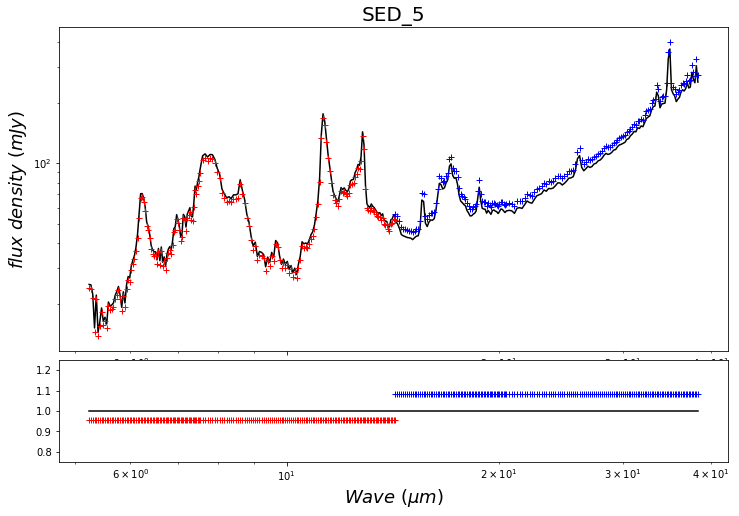

0.9623582602002154 1.0723308851277535
0.9623582606682876 1.0723308852877247
0.9623582610215403 1.0723308854581495


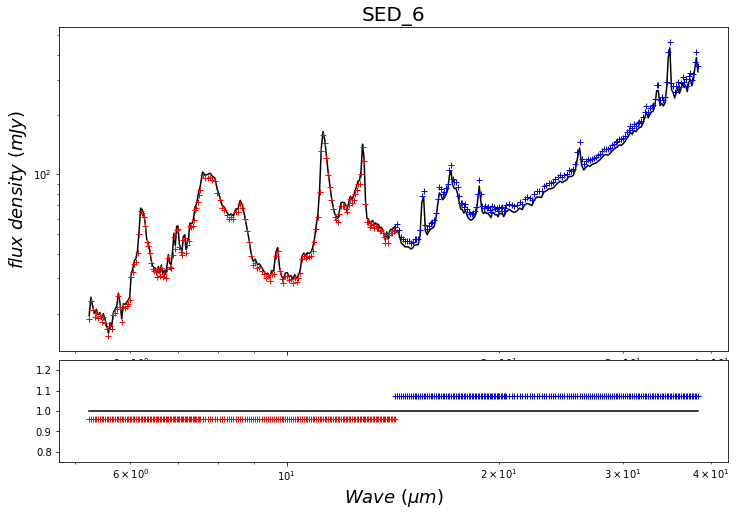

0.9891072385563476 1.001148005521786
0.9891072393757604 1.001148005675076
0.9891072404582462 1.0011480058338025


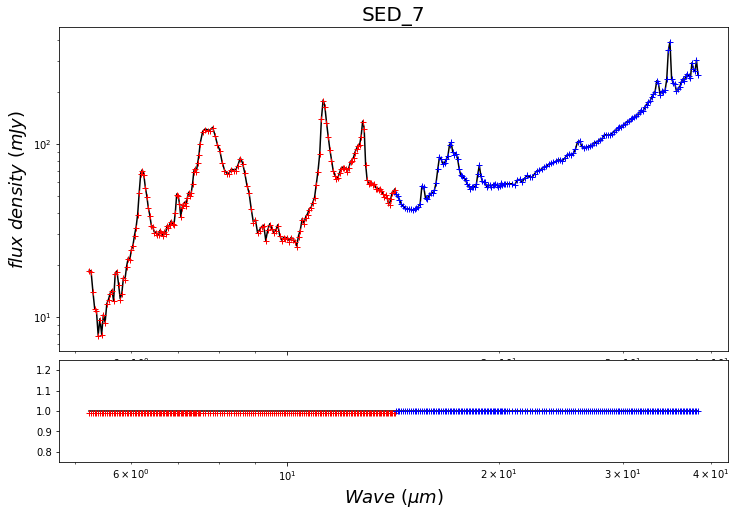

0.9556115866705476 1.1043545543448756
0.955611587293802 1.1043545545556934
0.9556115877377973 1.1043545547405276


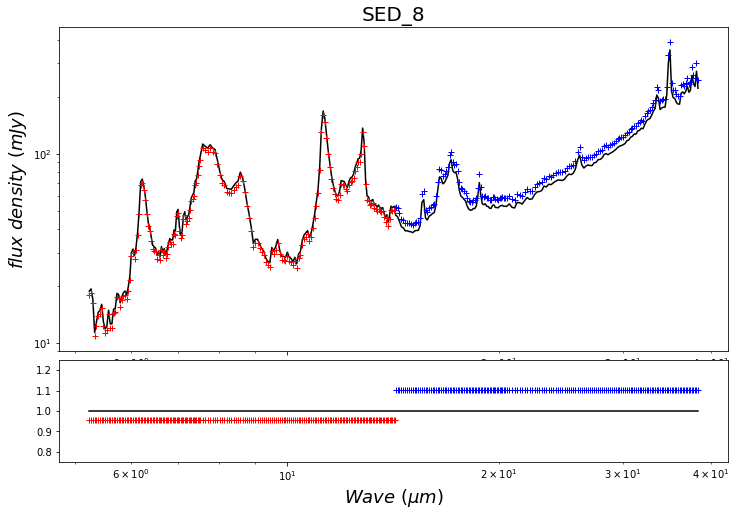

0.9791818204708791 1.021678301161794
0.9791818211447717 1.0216783013229314
0.9791818218068229 1.0216783014995146


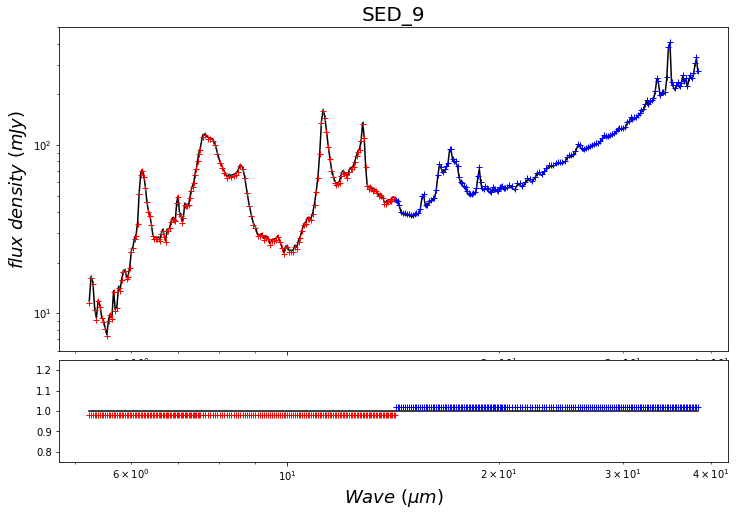

0.9822479912950802 1.024979781211031
0.9822479917535134 1.0249797813851995
0.9822479922143513 1.0249797816316994


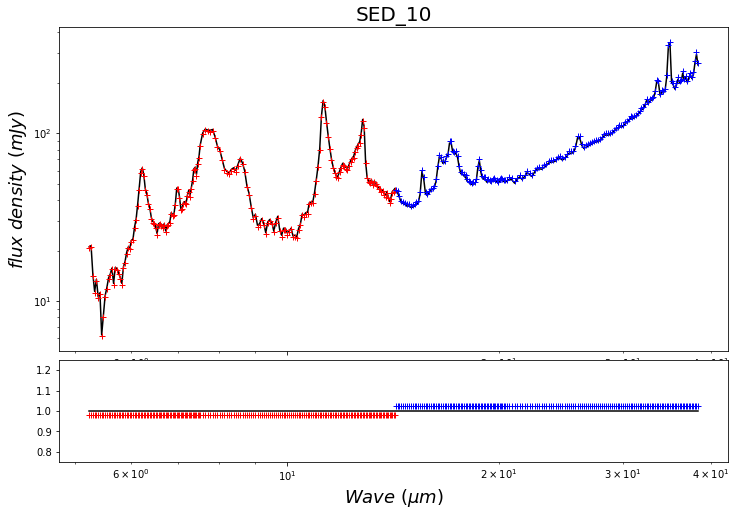

0.9728624946229277 1.0219283969420423
0.9728624955648065 1.0219283970940463
0.9728624983140289 1.0219283972694109


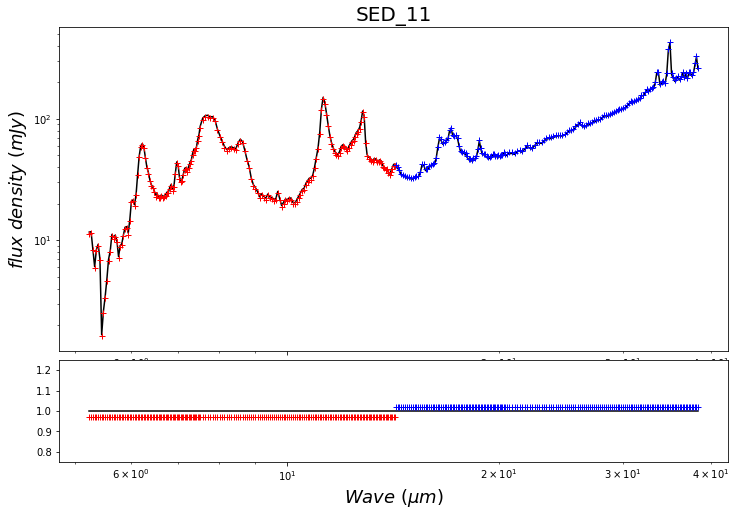

0.9968394611549092 0.9662942649099886
0.9968394620009342 0.9662942651505896
0.9968394633682686 0.966294265382393


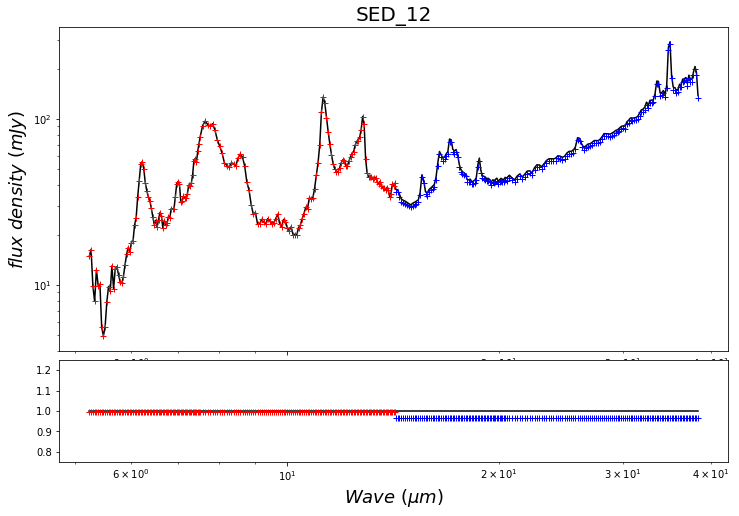

0.9974467470933713 0.9512105284057679
0.9974467481752581 0.9512105286325583
0.9974467492025142 0.9512105288472128


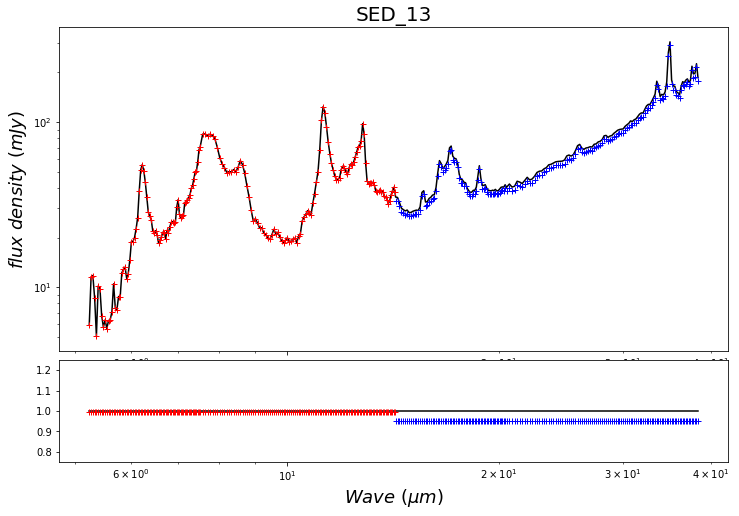

In [136]:
import os
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for ii in range(1,14):
    f = plt.figure(figsize=[12,8])
    gs0 = gridspec.GridSpec(1, 1)
    gs00 = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=gs0[0])
    ax1 = plt.Subplot(f, gs00[:-2])
    ax2 = plt.Subplot(f, gs00[-2:], sharex=ax1)
    fitrs_T = ascii.read('Calibration/ngc5194/Total/ngc5194_sed_{0}.tbl'.format(ii), format = 'ipac')
    ax1.plot(fitrs_T['wavelength'], fitrs_T['flux'], c = 'k')
    fitrs = ascii.read('Calibration/ngc5194/Only_SL/ngc5194_sed_{0}.tbl'.format(ii), format = 'ipac')
    ma = fitrs['band']=='0'
    fitrs_SL = fitrs[ma]
    ax1.plot(fitrs_SL['wavelength'], fitrs_SL['flux'], 'r+')
    fitrs = ascii.read('Calibration/ngc5194/Only_LL/ngc5194_sed_{0}.tbl'.format(ii), format = 'ipac')
    ma = fitrs['band']=='0'
    fitrs_LL = fitrs[ma]
    ax1.plot(fitrs_LL['wavelength'], fitrs_LL['flux'], 'b+')
    ma = fitrs_T['wavelength']>fitrs_SL['wavelength'].max()
    ax2.plot(fitrs_T['wavelength'], np.ones(len(fitrs_T['wavelength'])), 'k')
    ax2.plot(fitrs_T[~ma]['wavelength'], fitrs_SL['flux']/fitrs_T[~ma]['flux'], 'r+')
    ax2.plot(fitrs_T[ma]['wavelength'], fitrs_LL['flux']/fitrs_T[ma]['flux'], 'b+')
    print((fitrs_SL['flux']/fitrs_T[~ma]['flux']).min(), (fitrs_LL['flux']/fitrs_T[ma]['flux']).min())
    print((fitrs_SL['flux']/fitrs_T[~ma]['flux']).mean(), (fitrs_LL['flux']/fitrs_T[ma]['flux']).mean())
    print((fitrs_SL['flux']/fitrs_T[~ma]['flux']).max(), (fitrs_LL['flux']/fitrs_T[ma]['flux']).max())
    plt.setp(ax1.get_xticklabels(), visible=False)
    f.add_subplot(ax1)
    f.add_subplot(ax2)
    ax1.set_title('SED_{0}'.format(ii), fontsize=20)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_ylim(0.75, 1.25)
    ax1.set_ylabel('$flux\ density\ (mJy)$', fontsize=18)
    ax2.set_xlabel('$Wave\ (\\mu m)$', fontsize=18)
    plt.show()